# NIH CXR MultiLabel Classification

---
## Preparatory Set-up

In [1]:
#Import necessary Libraries
import pandas as pd
import numpy as np
import os

from PIL import Image
import matplotlib.pyplot as plt

import time
from tqdm import tqdm
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
import torchvision 
import torchvision.transforms as transforms
from torchvision.io import read_image 
from torchvision.utils import make_grid
from torchsummary import summary


from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

import timm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#Define Device to be used
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

print("Device being used: %s" %device)

There are 1 GPU(s) available.
We will use the GPU: Quadro RTX 8000
Device being used: cuda


---
## Importing and Cleaning Data

In [3]:
df = pd.read_csv('/scratch/odonnl02/CXR_Full_Directory.csv')
CXR_name_list = df.iloc[:, 0].tolist()
CXR_name_list.sort()

dir_path = '/scratch/odonnl02/CXR_Images'
dir_list = os.listdir(dir_path)
dir_list.sort()

if CXR_name_list == dir_list:
    print("The lists are identical")
    print('Folder List Lenght:', len(CXR_name_list))
    print('Directory List Lenght:', len(dir_list))
else:
    print("The lists are NOT identical")
    print('Folder List Lenght:', len(CXR_name_list))
    print('Directory List Lenght:', len(dir_list))

The lists are identical
Folder List Lenght: 112120
Directory List Lenght: 112120


In [4]:
#Filter list for important infection
df = pd.read_csv('/scratch/odonnl02/CXR_Full_Directory.csv')
df = df.iloc[:, [0,4,5,6,1]]
df = df.rename(columns = {'Image Index':'image_name',
                          'Patient Age':'age',
                          'Patient Gender':'sex',
                          'View Position':'view',
                          'Finding Labels':'labels'})

#Get Values of Each Label
counts = df['labels'].value_counts()
print(counts[0:20])

labels
No Finding                           60361
Infiltration                          9547
Atelectasis                           4215
Effusion                              3955
Nodule                                2705
Pneumothorax                          2194
Mass                                  2139
Effusion|Infiltration                 1603
Atelectasis|Infiltration              1350
Consolidation                         1310
Atelectasis|Effusion                  1165
Pleural_Thickening                    1126
Cardiomegaly                          1093
Emphysema                              892
Infiltration|Nodule                    829
Atelectasis|Effusion|Infiltration      737
Fibrosis                               727
Edema                                  628
Cardiomegaly|Effusion                  484
Consolidation|Infiltration             441
Name: count, dtype: int64


In [5]:
#Filter for values to do comparison for multilabel
counts_above_threshold = counts[counts>1000].index
counts_below_threshold = counts[counts<5000].index
comparison_list = set(counts_above_threshold) & set(counts_below_threshold)
print(comparison_list)

{'Effusion', 'Cardiomegaly', 'Nodule', 'Effusion|Infiltration', 'Atelectasis|Infiltration', 'Atelectasis', 'Pneumothorax', 'Atelectasis|Effusion', 'Mass', 'Pleural_Thickening', 'Consolidation'}


In [6]:
#Made a select list of disparent classes
select_list =['Atelectasis','Mass','Pneumothorax','Consolidation','Cardiomegaly','Fibrosis']

In [7]:
#Only include labels in eval list
df = df[df['labels'].isin(select_list)]

#Encoding Multilabels as binary present/non-present
mlb = MultiLabelBinarizer()
new_df = pd.DataFrame(mlb.fit_transform(df['labels'].str.split('|')),
                        columns=mlb.classes_,
                        index=df.index)
label_names = list(new_df.columns)
df = pd.concat([df,new_df],axis=1)

#Normalize Value For Age and Binary 'sex' and 'view'
df.insert(2, "age_normalized", round((df['age'] - df['age'].min()) / (df['age'].max() - df['age'].min()),6)) 
df['sex'] = np.where(df['sex']== 'M', 0, 1)
df['view'] = np.where(df['view']== 'AP', 0, 1)
df

,image_name,age,age_normalized,sex,view,labels,Atelectasis,Cardiomegaly,Consolidation,Fibrosis,Mass,Pneumothorax
0,00000001_000.png,58,0.368421,0,1,Cardiomegaly,0,1,0,0,0,0
23,00000008_000.png,69,0.440789,1,1,Cardiomegaly,0,1,0,0,0,0
34,00000011_006.png,75,0.480263,0,1,Atelectasis,1,0,0,0,0,0
49,00000013_011.png,60,0.381579,0,0,Pneumothorax,0,0,0,0,0,1
50,00000013_012.png,60,0.381579,0,0,Pneumothorax,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
112074,00030772_001.png,26,0.157895,1,0,Consolidation,0,0,1,0,0,0
112075,00030772_002.png,26,0.157895,1,0,Consolidation,0,0,1,0,0,0
112078,00030774_000.png,44,0.276316,1,1,Consolidation,0,0,1,0,0,0
112084,00030780_000.png,67,0.427632,0,1,Atelectasis,1,0,0,0,0,0


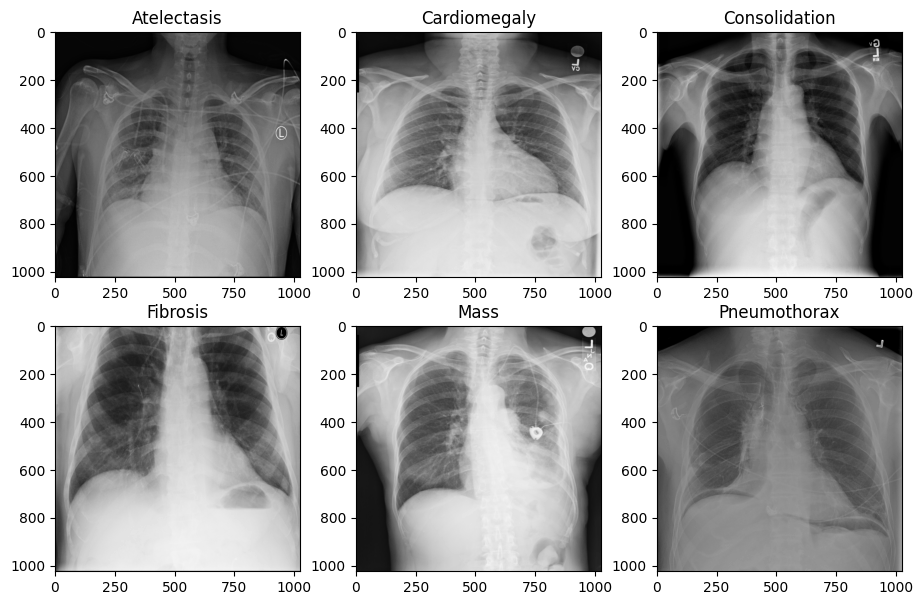

In [8]:
root = '/scratch/odonnl02/CXR_Images/'
img_dic = {}

for i in range(len(label_names)):
    running_list = []
    key = label_names[i]
    value = df[df['labels'] == key]
    value = value['image_name'].tolist()
    random_int = random.randint(0, len(value))
    value = value[random_int]    
    value = root+value
    img_dic[key] = value

i = 1
num_row = 2
num_column = int(len(label_names)/2)
plt.figure(figsize=(11,7))
for key, value in img_dic.items():
    image = Image.open(value)
    image = np.asarray(image)
    plt.subplot(num_row,num_column,i)
    plt.gca().set_title(key)
    plt.imshow(image, cmap='gray')
    i +=1

In [119]:
df.to_csv('df_filtered.csv', index = False)

#Make a list of all label names in order for future reference
unique_labels = df['labels'].unique()
print('Unique Labels Including Combined:', len(unique_labels), '\nValues:\n', unique_labels)
print('\nNumber of Separate Labels', len(label_names), '\nValues:\n', label_names)

Unique Labels Including Combined: 6 
Values:
 ['Cardiomegaly' 'Atelectasis' 'Pneumothorax' 'Mass' 'Fibrosis'
 'Consolidation']

Number of Separate Labels 6 
Values:
 ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Fibrosis', 'Mass', 'Pneumothorax']


---
## Separate Data into Training, Validation, and Test Sets

In [10]:
df = pd.read_csv('df_filtered.csv')

num_rows = df.shape[0]

train_amt = int(.7*num_rows)
val_amt = int(.1*num_rows)
test_amt = int(.2*num_rows)

idx = np.arange(num_rows)
np.random.shuffle(idx)

train_idx = idx[:train_amt]
val_idx = idx[train_amt:train_amt+val_amt]
test_idx = idx[train_amt+val_amt:]

train_df = df.iloc[train_idx,:]
val_df = df.iloc[val_idx,:]
test_df = df.iloc[test_idx,:]

In [11]:
train_df.to_csv('df_train.csv', index = False)
val_df.to_csv('df_validation.csv', index = False)
test_df.to_csv('df_test.csv', index = False)

In [12]:
def make_pie_chart(csv_path, title,label_names):
    df = pd.read_csv(csv_path)
    
    row_labels_list= []
    for index, row in df.iterrows():
        row_labels_list.append(list(row.iloc[6:]))
    
    row_labels_list = np.array(row_labels_list)
    
    ones_count_per_column = np.sum(row_labels_list, axis = 0)
    
    plt.figure(figsize=(8,8))
    plt.text(-1.5,1.6, title, fontweight='bold')
    pie_chart = plt.pie(ones_count_per_column, 
                        labels = label_names,
                        autopct = '%1.1d%%',
                        pctdistance=1.15,
                        labeldistance = 1.25,
                        rotatelabels = True)
    
    plt.show(pie_chart)

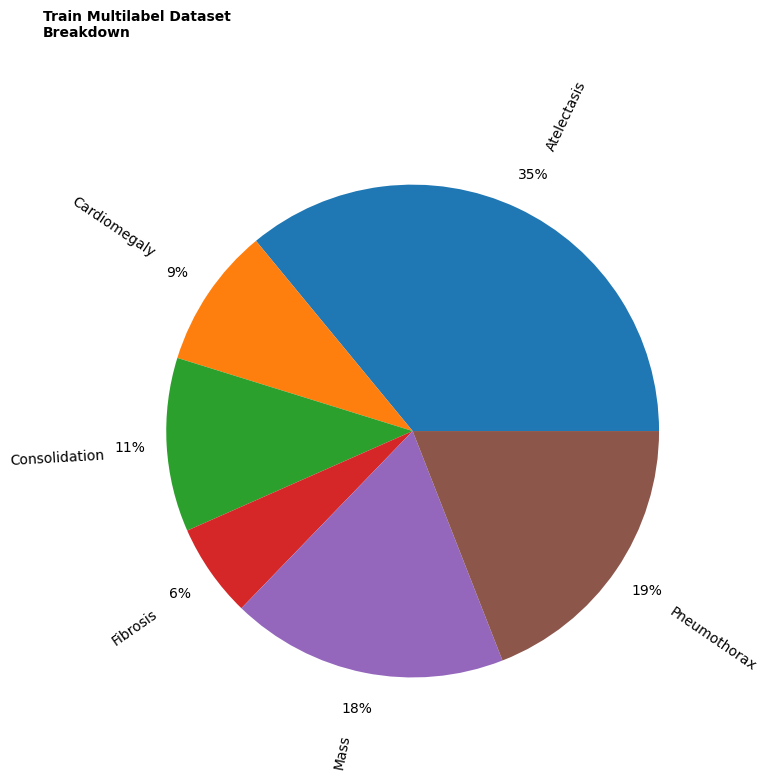

In [13]:
make_pie_chart('df_train.csv', 'Train Multilabel Dataset\nBreakdown',label_names)

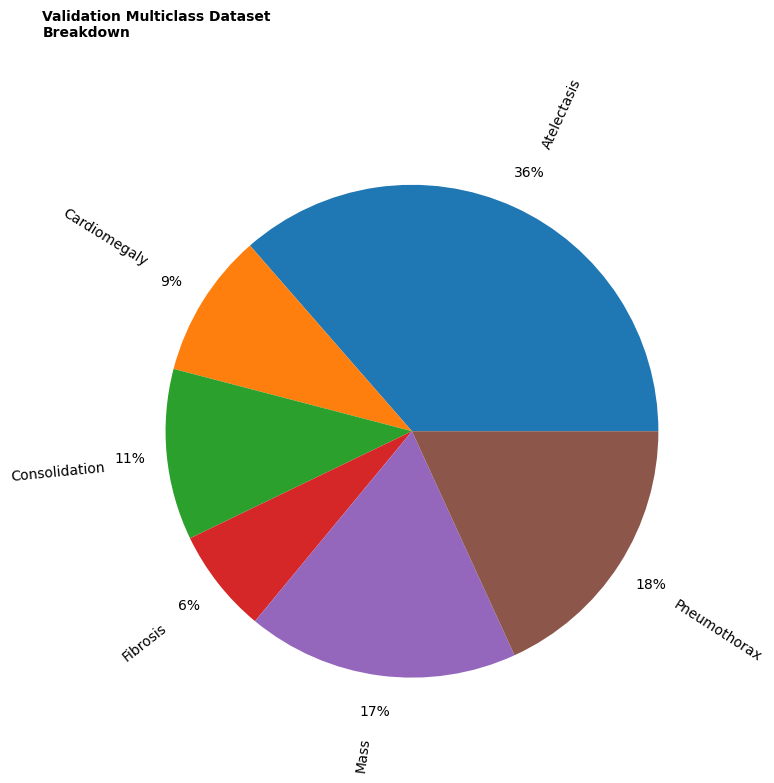

In [14]:
make_pie_chart('df_validation.csv', 'Validation Multiclass Dataset\nBreakdown',label_names)

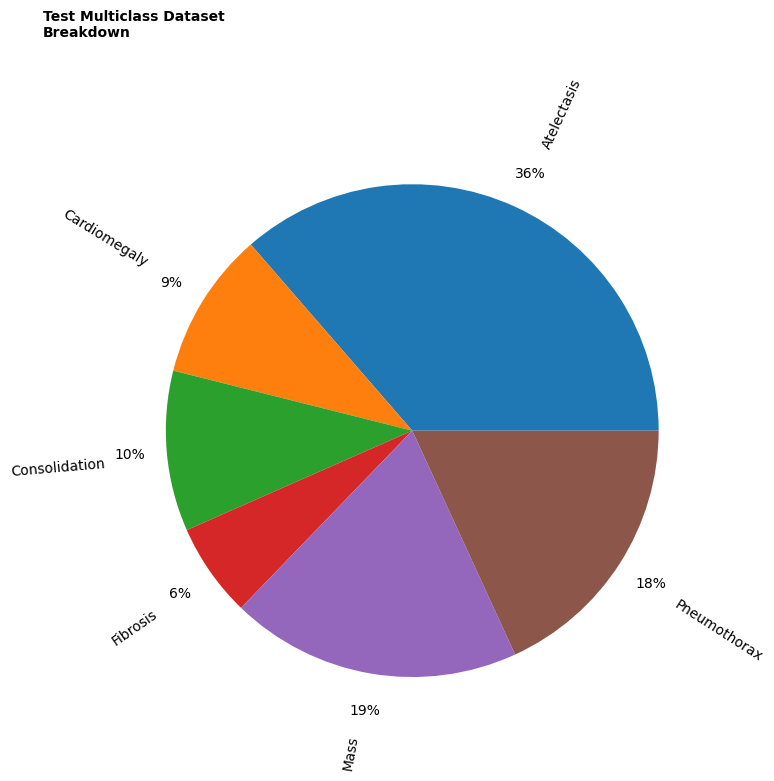

In [15]:
make_pie_chart('df_test.csv', 'Test Multiclass Dataset\nBreakdown', label_names)

---
## Balance Datasets

Trade-off between increased sample vs overfitting during sample. Decided to slightly upsample samples with number od data samples below 50% of the dominant label 

In [16]:
#Significant Class Imbalance, oversample the lower represented classes to be at least half majority class
def oversample(df_path,upsample_ratio):
    df = pd.read_csv(df_path)
    labels = df['labels'].value_counts().to_dict()
    most = max(labels.values())
    threshold = int(most*upsample_ratio)
    label_list_maintain = []
    label_list_oversample = []
    for key, value in labels.items():
        if value > threshold:
            label_list_maintain.append(df[df['labels'] == key]) 
        if value <= threshold:
            label_list_oversample.append(df[df['labels'] == key])
    label_sample = []
    for i in range(0,len(label_list_maintain)):
        label_sample.append(label_list_maintain[i])
    for i in range(0,len(label_list_oversample)):
        label_sample.append(label_list_oversample[i].sample(threshold, replace=True))
    final_df = pd.concat(label_sample)
    final_df = final_df.reset_index(drop=True)
    return final_df

Value counts by separate labels labels
Atelectasis      2940
Pneumothorax     2058
Mass             2058
Consolidation    2058
Cardiomegaly     2058
Fibrosis         2058
Name: count, dtype: int64


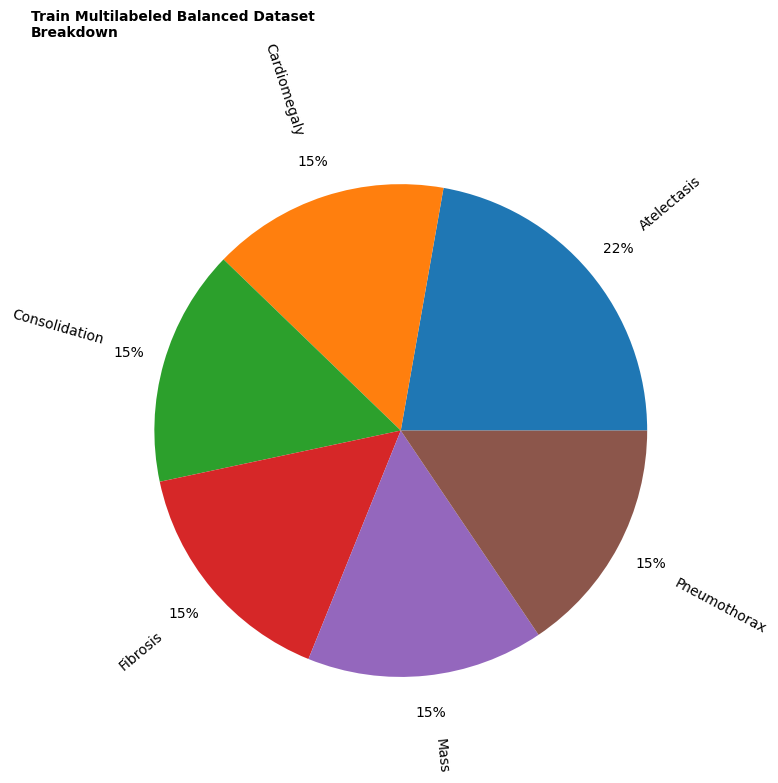

In [17]:
df = oversample('df_train.csv', 0.7)
counts = df['labels'].value_counts()
print('Value counts by separate labels', counts)
df.to_csv('df_balanced_train.csv', index = False)
make_pie_chart('df_balanced_train.csv', 'Train Multilabeled Balanced Dataset\nBreakdown',label_names)

Value counts by separate labels labels
Atelectasis      425
Pneumothorax     297
Mass             297
Consolidation    297
Cardiomegaly     297
Fibrosis         297
Name: count, dtype: int64


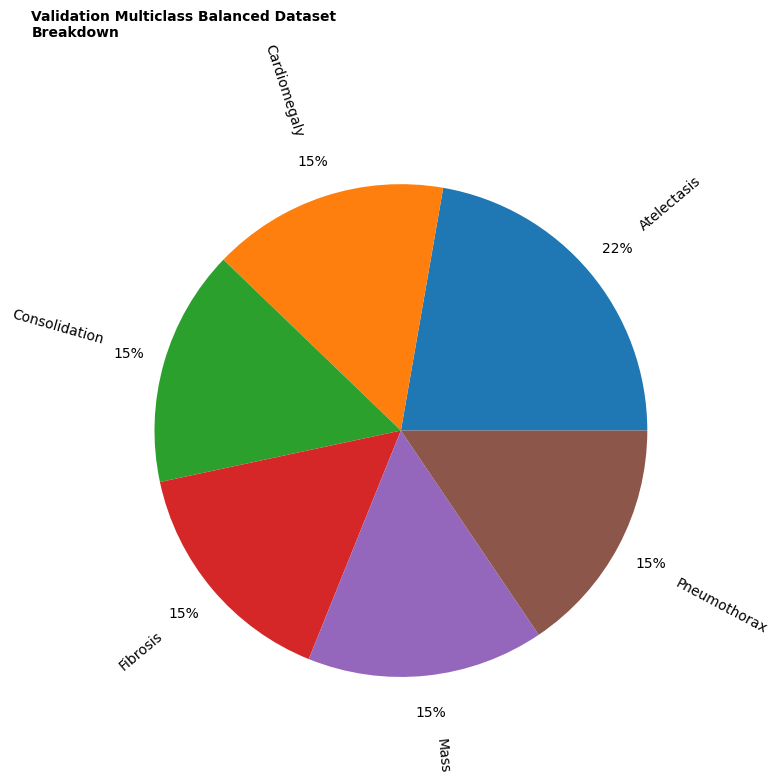

In [18]:
df = oversample('df_validation.csv', 0.7)
counts = df['labels'].value_counts()
print('Value counts by separate labels', counts)
df.to_csv('df_balanced_validation.csv', index = False)
make_pie_chart('df_balanced_validation.csv', 'Validation Multiclass Balanced Dataset\nBreakdown',label_names)

---

## Load Data For Models

In [18]:
class CXR_MultiLabel_Dataset(Dataset):

    def __init__(self, csv_file, root_dir):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = self.data_frame.iloc[idx, 0]   
        img_path = self.root_dir+img_name
        
        img = Image.open(img_path)
        img = np.asarray(img)
        min_image = np.min(img)
        max_image = np.max(img)
        img = (img - min_image)/(max_image - min_image + 1e-4)
        img = torch.tensor(img).unsqueeze(0).float()
        if img.dim() != 3:
            img = img[:,:,:,0]
        
        label = self.data_frame.iloc[idx,6:]
        label = torch.tensor(label).float()

        non_image_data = self.data_frame.iloc[idx,2:5]
        non_image_data = torch.tensor(non_image_data).float()
        
        sample = {'image': img, 'non_image_data': non_image_data,'label': label}
        
        return sample

In [19]:
#Upload Data from CSV files and directories with images
root_dir = '/scratch/odonnl02/CXR_Images/'
csv_file_train = 'df_balanced_train.csv'
csv_file_validation = 'df_balanced_validation.csv'
csv_file_test = 'df_test.csv'

train_dataset = CXR_MultiLabel_Dataset(csv_file = csv_file_train, root_dir = root_dir)

validation_dataset = CXR_MultiLabel_Dataset(csv_file = csv_file_validation, root_dir = root_dir)

test_dataset = CXR_MultiLabel_Dataset(csv_file = csv_file_test, root_dir = root_dir)

In [20]:
#Load data into dataloader
batch_size = 16

train_dataloader = DataLoader(train_dataset, 
                              shuffle = True, 
                              batch_size = batch_size,
                              drop_last = True)

validation_dataloader = DataLoader(validation_dataset, 
                              shuffle = True, 
                              batch_size = batch_size,
                              drop_last = True)

test_dataloader = DataLoader(test_dataset, 
                              shuffle = False, 
                              batch_size = batch_size,
                              drop_last = True)

In [21]:
#verify loaking correctly
sample = next(iter(train_dataloader))
print('Dataloader Shape:', len(train_dataloader))
print('Dataloader Images Shape:', sample['image'].shape)
print('Dataloader Non-Image Data Shape:', sample['non_image_data'].shape)
print('Dataloader Labels Shape:', sample['label'].shape)

Dataloader Shape: 826
Dataloader Images Shape: torch.Size([16, 1, 1024, 1024])
Dataloader Non-Image Data Shape: torch.Size([16, 3])
Dataloader Labels Shape: torch.Size([16, 6])


---

## Define Train Function, Test Eval Function

In [22]:
def train_model(model,train_dataloader,validation_dataloader, optimizer, loss_fn, num_epoch, threshold, include_non_image_data, model_file):
    start_time = time.time()
    best_acc = 0
    
    t_acc_per_epoch = []
    t_loss_per_epoch = []
    t_f1_per_epoch = []
    
    v_acc_per_epoch = []
    v_loss_per_epoch = []
    v_f1_per_epoch = []
        
    for epoch in range(num_epoch):
        print(f"Epoch: {epoch+1}".center(80, '*'))
        
        running_correct = 0
        running_loss = 0
        running_total = 0
        running_f1 = 0
       
        model.train()
        print('Training Phase:')
        for i, sample_dic in enumerate( tqdm(train_dataloader) ):
            #Import data
            images = sample_dic['image'].to(device)
            non_image_data = sample_dic['non_image_data'].to(device)
            labels = sample_dic['label'].to(device)

            #run model with or without non visual data
            if include_non_image_data == True:
                outputs = model(images, non_image_data)
            else:
                outputs = model(images)
                
            optimizer.zero_grad()
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, dim = 1)
            _, labels = torch.max(labels, dim = 1)
            
            num_imgs = labels.size()[0]
            running_total += num_imgs
            
            running_correct += (preds ==labels).sum().item()
            running_loss += loss.item()*num_imgs
            running_f1 += f1_score(preds, labels, average = 'weighted', zero_division = 0)

        #Calculate averages for Epoch
        avg_epoch_acc = running_correct/running_total
        avg_epoch_loss = running_loss/running_total
        avg_epoch_f1 = running_f1/running_total

        #Save in Lists
        t_acc_per_epoch.append(avg_epoch_acc)
        t_loss_per_epoch.append(avg_epoch_loss)
        t_f1_per_epoch.append(avg_epoch_f1)

        print(f'Train set:\n\t Average Accuracy For Epoch: {avg_epoch_acc} \n\t Average Cross Entropy Loss for Epoch: {avg_epoch_loss}\n\t Average F1 for Epoch: {avg_epoch_f1}')
                
        print('Validation Phase:')
        model.eval()
        with torch.no_grad():
            running_correct = 0
            running_loss = 0
            running_total = 0
            running_f1 = 0
            for i, sample_dic in enumerate( tqdm(validation_dataloader) ):
                images = sample_dic['image'].to(device)
                non_image_data = sample_dic['non_image_data'].to(device)
                labels = sample_dic['label'].to(device)
                
                if include_non_image_data == True:
                    outputs = model(images, non_image_data)
                else:
                    outputs = model(images)
                
                loss = loss_fn(outputs, labels)
                
                _, preds = torch.max(outputs, dim = 1)
                _, labels = torch.max(labels, dim = 1)

                num_imgs = labels.size()[0]
                running_total += num_imgs
                
                running_correct += (preds ==labels).sum().item()
                running_loss += loss.item()*num_imgs
                running_f1 += f1_score(preds, labels, average = 'weighted', zero_division = 0)
            
            avg_epoch_acc = running_correct/running_total
            avg_epoch_loss = running_loss/running_total
            avg_epoch_f1 = running_f1/running_total
            
            if avg_epoch_acc > best_acc:
                best_acc = avg_epoch_acc
                best_model_wts = model.state_dict()
                
            v_acc_per_epoch.append(avg_epoch_acc)
            v_loss_per_epoch.append(avg_epoch_loss)
            v_f1_per_epoch.append(avg_epoch_f1)
            
            elapse = time.strftime('%H:%M:%S', time.gmtime(int((time.time() - start_time))))
            print(f'Validation set: \n\t Average Accuracy: {avg_epoch_acc} \n\t Average Cross Entropy Loss: {avg_epoch_loss}\n\t Average F1 for Epoch: {avg_epoch_f1} \nTime elapse: {elapse}')   

    #Provide model with best weights for accuracy
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), model_file)
    
    return model, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch

In [32]:
def model_eval(model, test_dataloader, include_non_image_data):
    correct = 0
    total = 0
    predictions = []
    truths = []
    
    model.eval()
    with torch.no_grad():
        for i, sample_dic in enumerate( tqdm(test_dataloader) ):
            image = sample_dic['image'].to(device)
            non_image_data = sample_dic['non_image_data'].to(device)
            label = sample_dic['label'].to(device)
            labels = label.squeeze().detach().cpu().numpy()
            
            for label in labels:
                truths.append(label)
                
            if include_non_image_data == False:
                outputs = model(image)
            if include_non_image_data == True:
                outputs = model(image, non_image_data)
                
            outputs = outputs.squeeze().detach().cpu().numpy()
            for output in outputs:
                predictions.append(output)
            
        truths = np.stack(truths)
        truths = torch.tensor(truths)
        predictions = np.stack(predictions)
        predictions = torch.tensor(predictions)
        
    return truths, predictions

---

## Define Evaluation Functions

In [33]:
def plot_train_metrics(model_name, num_epoch, t_acc_per_epoch, t_loss_per_epoch, t_F1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_F1_per_epoch):
    plt.figure(figsize=(6,10))
    
    plt.subplot(3, 1, 1)
    plt.plot(t_loss_per_epoch, color = 'b', label = 'Training')
    plt.plot(v_loss_per_epoch, color = 'g', label = 'Validation')
    plt.xticks(np.arange(num_epoch), np.arange(1, num_epoch+1))
    plt.title(f'{model_name}\nTraining/Validation Average Loss Per Epoch')
    plt.legend()
    
    plt.subplot(3, 1, 2)
    plt.plot(t_acc_per_epoch, color = 'b', label = 'Training')
    plt.plot(v_acc_per_epoch, color = 'g', label = 'Validation')
    plt.xticks(np.arange(num_epoch), np.arange(1, num_epoch+1))
    plt.title(f'{model_name}\nTraining/Validation Accuracy Per Epoch')

    plt.subplot(3, 1, 3)
    plt.plot(t_F1_per_epoch, color = 'b', label = 'Training')
    plt.plot(v_F1_per_epoch, color = 'g', label = 'Validation')
    plt.xticks(np.arange(num_epoch), np.arange(1, num_epoch+1))
    plt.title(f'{model_name}\nTraining/Validation F1 Score Per Epoch')
    
    plt.tight_layout()
    plt.show()

In [55]:
def multilabel_ROC_plot(truths, predictions, title, label_names):
    n_labels = len(label_names)
    df_labels = pd.DataFrame(truths)
    df_preds = pd.DataFrame(predictions)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_labels):
        fpr[i], tpr[i], _ = roc_curve(df_labels.iloc[:, i], df_preds.iloc[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    truths = np.array(truths)
    predictions = np.array(predictions)
    fpr["weighted"], tpr["weighted"], _ = roc_curve(truths.ravel(), predictions.ravel())
    roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])
    
    plt.figure(figsize=(8,8))
    plt.plot(fpr["weighted"], tpr["weighted"], label='Weighted-average ROC curve (area = {0:0.2f})'.format(roc_auc["weighted"]))
    for i in range(n_labels):
        plt.plot(fpr[i], tpr[i], label='ROC curve of {0} (area = {1:0.2f})'.format(label_names[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [35]:
def predictions_w_thresholds(truths, predictions,threshold):
    truths = torch.where(truths > threshold, 1.0, 0.0)
    predictions = torch.where(predictions > threshold, 1.0, 0.0)
    return truths, predictions

---
## MLP Model - Images Only

In [13]:
class MLP(nn.Module):
    def __init__(self,input_size,out_size):
        super().__init__()
        
        self.input_fc = nn.Linear(in_features=input_size,
                                  out_features=512,
                                  bias = True)
        self.hidden1_fc = nn.Linear(in_features=512, 
                                    out_features=256,
                                    bias = True)
        self.hidden2_fc = nn.Linear(in_features=256,
                                    out_features=128,
                                    bias = True)
        self.hidden3_fc = nn.Linear(in_features=128,
                                    out_features=out_size,
                                    bias = True)
    
    def forward(self, x):
        x = x.squeeze()
        x = x.view(x.shape[0],-1)
        x = torch.relu(self.input_fc(x))
        x = torch.relu(self.hidden1_fc(x))
        x = torch.relu(self.hidden2_fc(x))
        x = torch.relu(self.hidden3_fc(x))

        return x

In [14]:
input_size = 1024*1024
out_size = len(label_names)

model = MLP(input_size = input_size, out_size=out_size)
input_shape = (1,1024,1024)
summary(model.to(device), input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]     536,871,424
            Linear-2                  [-1, 256]         131,328
            Linear-3                  [-1, 128]          32,896
            Linear-4                    [-1, 6]             774
Total params: 537,036,422
Trainable params: 537,036,422
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 4.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2048.63
Estimated Total Size (MB): 2052.64
----------------------------------------------------------------


In [28]:
#Set Parameters for Training MLP Model only on image data
input_size = 1024*1024
out_size = len(label_names)
model = MLP(input_size = input_size,out_size=out_size).to(device)
train_dataloader = train_dataloader
validation_dataloader = validation_dataloader
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
num_epoch = 12
threshold = 0.5
include_non_image_data = False
model_file = 'MPL_ImageOnly_Model.pth'

model, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch = train_model(model,
                                                                                                                          train_dataloader,
                                                                                                                          validation_dataloader,
                                                                                                                          optimizer,
                                                                                                                          loss_fn,
                                                                                                                          num_epoch,
                                                                                                                          threshold,
                                                                                                                          include_non_image_data, model_file)

************************************Epoch: 1************************************
Training Phase:


100%|██████████| 826/826 [07:03<00:00,  1.95it/s]


Train set:
	 Average Accuracy For Epoch: 0.22207929782082325 
	 Average Cross Entropy Loss for Epoch: 1.806005042488292
	 Average F1 for Epoch: 0.022003619679686108
Validation Phase:


100%|██████████| 119/119 [00:55<00:00,  2.13it/s]


Validation set: 
	 Average Accuracy: 0.22163865546218486 
	 Average Cross Entropy Loss: 1.8061452352700114
	 Average F1 for Epoch: 0.02179235549218726 
Time elapse: 00:07:59
************************************Epoch: 2************************************
Training Phase:


100%|██████████| 826/826 [05:26<00:00,  2.53it/s]


Train set:
	 Average Accuracy For Epoch: 0.22223062953995157 
	 Average Cross Entropy Loss for Epoch: 1.8060049665753548
	 Average F1 for Epoch: 0.021968580322440902
Validation Phase:


100%|██████████| 119/119 [00:43<00:00,  2.76it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.8061452332664938
	 Average F1 for Epoch: 0.021933659908160225 
Time elapse: 00:14:08
************************************Epoch: 3************************************
Training Phase:


100%|██████████| 826/826 [05:02<00:00,  2.73it/s]


Train set:
	 Average Accuracy For Epoch: 0.22230629539951574 
	 Average Cross Entropy Loss for Epoch: 1.8060806344554152
	 Average F1 for Epoch: 0.021966806634764358
Validation Phase:


100%|██████████| 119/119 [00:36<00:00,  3.22it/s]


Validation set: 
	 Average Accuracy: 0.22321428571428573 
	 Average Cross Entropy Loss: 1.8058826262209595
	 Average F1 for Epoch: 0.022127395156270154 
Time elapse: 00:19:47
************************************Epoch: 4************************************
Training Phase:


100%|██████████| 826/826 [04:59<00:00,  2.76it/s]


Train set:
	 Average Accuracy For Epoch: 0.2223819612590799 
	 Average Cross Entropy Loss for Epoch: 1.8061184656533433
	 Average F1 for Epoch: 0.022044252628223345
Validation Phase:


100%|██████████| 119/119 [00:37<00:00,  3.19it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.805620024184219
	 Average F1 for Epoch: 0.02188912659660386 
Time elapse: 00:25:23
************************************Epoch: 5************************************
Training Phase:


100%|██████████| 826/826 [06:29<00:00,  2.12it/s]


Train set:
	 Average Accuracy For Epoch: 0.22230629539951574 
	 Average Cross Entropy Loss for Epoch: 1.805929302736287
	 Average F1 for Epoch: 0.022004590786202136
Validation Phase:


100%|██████████| 119/119 [00:59<00:00,  1.98it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.8061452202436303
	 Average F1 for Epoch: 0.02205925891855207 
Time elapse: 00:32:52
************************************Epoch: 6************************************
Training Phase:


100%|██████████| 826/826 [05:44<00:00,  2.40it/s]


Train set:
	 Average Accuracy For Epoch: 0.2223819612590799 
	 Average Cross Entropy Loss for Epoch: 1.805967133934215
	 Average F1 for Epoch: 0.02202168178854597
Validation Phase:


100%|██████████| 119/119 [00:45<00:00,  2.61it/s]


Validation set: 
	 Average Accuracy: 0.22216386554621848 
	 Average Cross Entropy Loss: 1.8058826202104072
	 Average F1 for Epoch: 0.021963543021519292 
Time elapse: 00:39:23
************************************Epoch: 7************************************
Training Phase:


100%|██████████| 826/826 [05:11<00:00,  2.65it/s]


Train set:
	 Average Accuracy For Epoch: 0.22230629539951574 
	 Average Cross Entropy Loss for Epoch: 1.8059293021590024
	 Average F1 for Epoch: 0.02201512775121078
Validation Phase:


100%|██████████| 119/119 [00:35<00:00,  3.34it/s]


Validation set: 
	 Average Accuracy: 0.22321428571428573 
	 Average Cross Entropy Loss: 1.8053574111281323
	 Average F1 for Epoch: 0.022145054499975173 
Time elapse: 00:45:10
************************************Epoch: 8************************************
Training Phase:


100%|██████████| 826/826 [04:58<00:00,  2.77it/s]


Train set:
	 Average Accuracy For Epoch: 0.22207929782082325 
	 Average Cross Entropy Loss for Epoch: 1.8061184676738398
	 Average F1 for Epoch: 0.021995429040404926
Validation Phase:


100%|██████████| 119/119 [00:41<00:00,  2.85it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.806407826287406
	 Average F1 for Epoch: 0.02204873946543824 
Time elapse: 00:50:50
************************************Epoch: 9************************************
Training Phase:


100%|██████████| 826/826 [07:46<00:00,  1.77it/s]


Train set:
	 Average Accuracy For Epoch: 0.22207929782082325 
	 Average Cross Entropy Loss for Epoch: 1.8061184689727303
	 Average F1 for Epoch: 0.02201334976723115
Validation Phase:


100%|██████████| 119/119 [01:02<00:00,  1.91it/s]


Validation set: 
	 Average Accuracy: 0.22216386554621848 
	 Average Cross Entropy Loss: 1.8058826252192008
	 Average F1 for Epoch: 0.022043631347308364 
Time elapse: 00:59:39
***********************************Epoch: 10************************************
Training Phase:


100%|██████████| 826/826 [08:05<00:00,  1.70it/s]


Train set:
	 Average Accuracy For Epoch: 0.22207929782082325 
	 Average Cross Entropy Loss for Epoch: 1.8060806322905978
	 Average F1 for Epoch: 0.021985683862527316
Validation Phase:


100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.805882621212166
	 Average F1 for Epoch: 0.0219237895233963 
Time elapse: 01:08:48
***********************************Epoch: 11************************************
Training Phase:


100%|██████████| 826/826 [08:25<00:00,  1.64it/s]


Train set:
	 Average Accuracy For Epoch: 0.22223062953995157 
	 Average Cross Entropy Loss for Epoch: 1.8059293014373965
	 Average F1 for Epoch: 0.021967601227428985
Validation Phase:


100%|██████████| 119/119 [01:06<00:00,  1.78it/s]


Validation set: 
	 Average Accuracy: 0.22321428571428573 
	 Average Cross Entropy Loss: 1.8061452312629764
	 Average F1 for Epoch: 0.0220801827585825 
Time elapse: 01:18:21
***********************************Epoch: 12************************************
Training Phase:


100%|██████████| 826/826 [08:16<00:00,  1.66it/s]


Train set:
	 Average Accuracy For Epoch: 0.22230629539951574 
	 Average Cross Entropy Loss for Epoch: 1.8060428003710638
	 Average F1 for Epoch: 0.022008990153095116
Validation Phase:


100%|██████████| 119/119 [01:07<00:00,  1.76it/s]


Validation set: 
	 Average Accuracy: 0.22321428571428573 
	 Average Cross Entropy Loss: 1.8061452202436303
	 Average F1 for Epoch: 0.022267824190988095 
Time elapse: 01:27:45


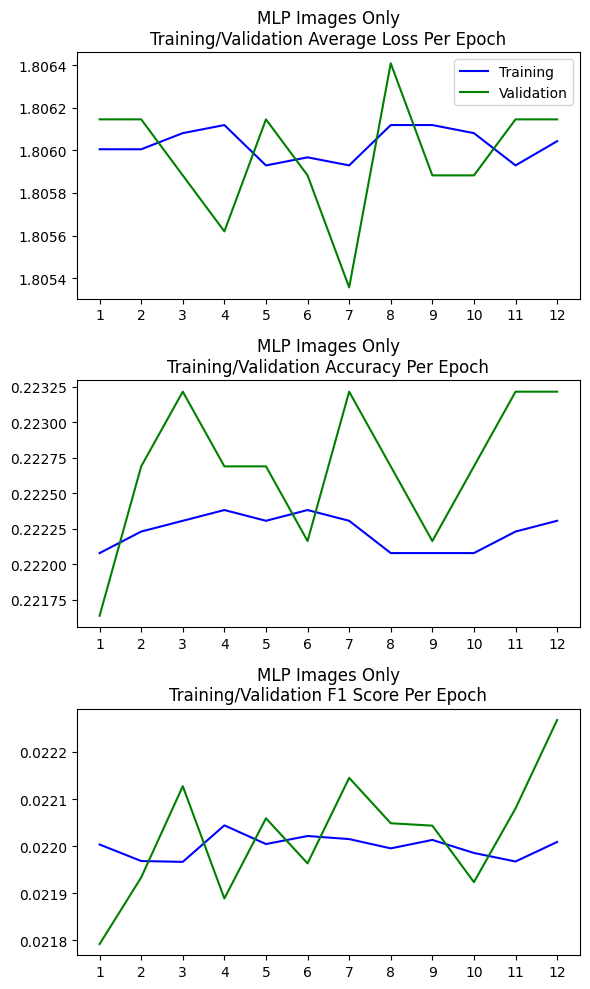

In [29]:
plot_train_metrics('MLP Images Only', num_epoch, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch)

In [56]:
#Load Trained Model
input_size = 1024*1024
out_size = len(label_names)
model = MLP(input_size = input_size,out_size=out_size).to(device)
model.load_state_dict(torch.load('MPL_ImageOnly_Model.pth'))
model.eval()

MLP(
  (input_fc): Linear(in_features=1048576, out_features=512, bias=True)
  (hidden1_fc): Linear(in_features=512, out_features=256, bias=True)
  (hidden2_fc): Linear(in_features=256, out_features=128, bias=True)
  (hidden3_fc): Linear(in_features=128, out_features=6, bias=True)
)

In [63]:
#Eval Trained Model
model = model
test_dataloader = test_dataloader
include_non_image_data = False

truths, predictions = model_eval(model, test_dataloader, include_non_image_data)

100%|██████████| 146/146 [00:37<00:00,  3.88it/s]


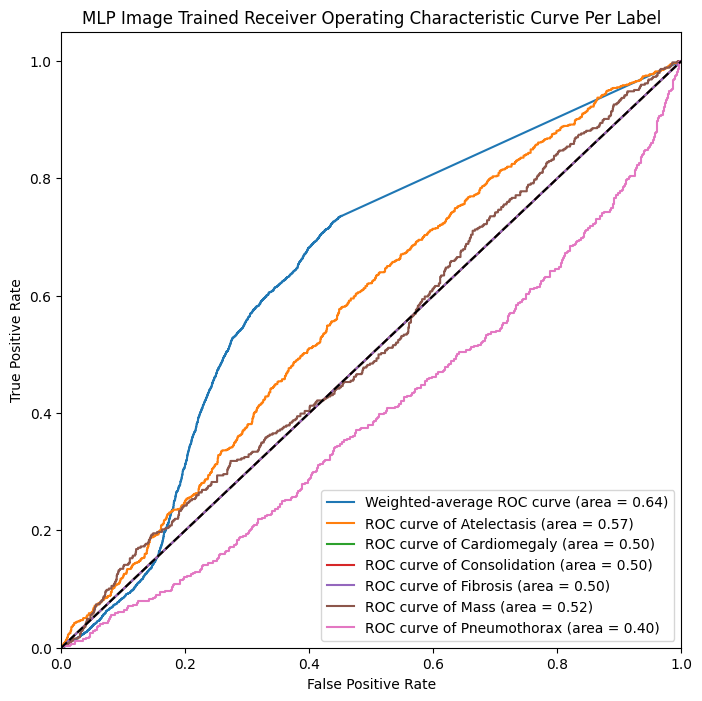

In [64]:
title = 'MLP Image Trained Receiver Operating Characteristic Curve Per Label'
multilabel_ROC_plot(truths, predictions, title, label_names)

In [65]:
truths, predictions = predictions_w_thresholds(truths, predictions,0.5)

print(classification_report(truths, predictions,target_names=label_names,zero_division = 0))

               precision    recall  f1-score   support

  Atelectasis       0.36      1.00      0.53       850
 Cardiomegaly       0.00      0.00      0.00       227
Consolidation       0.00      0.00      0.00       245
     Fibrosis       0.00      0.00      0.00       144
         Mass       0.19      1.00      0.32       446
 Pneumothorax       0.18      1.00      0.31       424

    micro avg       0.25      0.74      0.37      2336
    macro avg       0.12      0.50      0.19      2336
 weighted avg       0.20      0.74      0.31      2336
  samples avg       0.25      0.74      0.37      2336



---
## MLP Model - Images and Non-Visual Data

In [66]:
class MLP_w_NVdata(nn.Module):
    def __init__(self,input_size,out_size):
        super().__init__()
        
        self.input_fc = nn.Linear(in_features=input_size,
                                  out_features=512,
                                  bias = True)
        self.hidden1_fc = nn.Linear(in_features=512, 
                                    out_features=256,
                                    bias = True)
        self.hidden2_fc = nn.Linear(in_features=256,
                                    out_features=128,
                                    bias = True)
        self.hidden3_fc = nn.Linear(in_features=128+3,
                                    out_features=out_size,
                                    bias = True)
    
    def forward(self, image, non_visual_data):
        x = image.squeeze()
        x = x.view(x.shape[0],-1)
        x = torch.relu(self.input_fc(x))
        x = torch.relu(self.hidden1_fc(x))
        x = torch.relu(self.hidden2_fc(x))
        
        z = non_visual_data.squeeze()
        z = z.view(x.shape[0],-1)
        
        x = torch.cat((x,z),1)
        
        x = torch.relu(self.hidden3_fc(x))
        
        return x

In [20]:
#Set Parameters for Training MLP Model Including Imaging and Non-Imaging data

input_size = 1024*1024
out_size = len(label_names)
model = MLP_w_NVdata(input_size = input_size,out_size=out_size).to(device)
train_dataloader = train_dataloader
validation_dataloader = validation_dataloader
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
num_epoch = 12
threshold = 0.5
include_non_image_data = True
model_file = 'MPL_Image_w_NV_Model.pth'

model, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch = train_model(model,
                                                                                                                          train_dataloader,
                                                                                                                          validation_dataloader,
                                                                                                                          optimizer,
                                                                                                                          loss_fn,
                                                                                                                          num_epoch,
                                                                                                                          threshold,
                                                                                                                          include_non_image_data, model_file)

************************************Epoch: 1************************************
Training Phase:


100%|██████████| 826/826 [09:11<00:00,  1.50it/s]


Train set:
	 Average Accuracy For Epoch: 0.22223062953995157 
	 Average Cross Entropy Loss for Epoch: 10.169400378809136
	 Average F1 for Epoch: 0.02201823860486142
Validation Phase:


100%|██████████| 119/119 [01:06<00:00,  1.80it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.7917594909667969
	 Average F1 for Epoch: 0.02221885723578496 
Time elapse: 00:10:18
************************************Epoch: 2************************************
Training Phase:


100%|██████████| 826/826 [08:01<00:00,  1.71it/s]


Train set:
	 Average Accuracy For Epoch: 0.22230629539951574 
	 Average Cross Entropy Loss for Epoch: 1.7917594909667969
	 Average F1 for Epoch: 0.021987913711730648
Validation Phase:


100%|██████████| 119/119 [01:06<00:00,  1.79it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.7917594909667969
	 Average F1 for Epoch: 0.02208354827550436 
Time elapse: 00:19:26
************************************Epoch: 3************************************
Training Phase:


100%|██████████| 826/826 [08:49<00:00,  1.56it/s]


Train set:
	 Average Accuracy For Epoch: 0.22245762711864406 
	 Average Cross Entropy Loss for Epoch: 1.7917594909667969
	 Average F1 for Epoch: 0.0219785036322855
Validation Phase:


100%|██████████| 119/119 [01:08<00:00,  1.75it/s]


Validation set: 
	 Average Accuracy: 0.22111344537815125 
	 Average Cross Entropy Loss: 1.7917594909667969
	 Average F1 for Epoch: 0.021977654957364243 
Time elapse: 00:29:23
************************************Epoch: 4************************************
Training Phase:


100%|██████████| 826/826 [09:28<00:00,  1.45it/s]


Train set:
	 Average Accuracy For Epoch: 0.22223062953995157 
	 Average Cross Entropy Loss for Epoch: 1.7917594909667969
	 Average F1 for Epoch: 0.02203254651080362
Validation Phase:


100%|██████████| 119/119 [01:06<00:00,  1.80it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.7917594909667969
	 Average F1 for Epoch: 0.022049353399382954 
Time elapse: 00:39:58
************************************Epoch: 5************************************
Training Phase:


100%|██████████| 826/826 [07:45<00:00,  1.77it/s]


Train set:
	 Average Accuracy For Epoch: 0.22223062953995157 
	 Average Cross Entropy Loss for Epoch: 1.7917594909667969
	 Average F1 for Epoch: 0.02198172246771151
Validation Phase:


100%|██████████| 119/119 [00:56<00:00,  2.11it/s]


Validation set: 
	 Average Accuracy: 0.22321428571428573 
	 Average Cross Entropy Loss: 1.7917594909667969
	 Average F1 for Epoch: 0.022187751698124942 
Time elapse: 00:48:40
************************************Epoch: 6************************************
Training Phase:


100%|██████████| 826/826 [07:41<00:00,  1.79it/s]


Train set:
	 Average Accuracy For Epoch: 0.22200363196125908 
	 Average Cross Entropy Loss for Epoch: 1.7917594909667969
	 Average F1 for Epoch: 0.022022989094537777
Validation Phase:


100%|██████████| 119/119 [01:05<00:00,  1.80it/s]


Validation set: 
	 Average Accuracy: 0.22216386554621848 
	 Average Cross Entropy Loss: 1.7917594909667969
	 Average F1 for Epoch: 0.022022305334636838 
Time elapse: 00:57:28
************************************Epoch: 7************************************
Training Phase:


100%|██████████| 826/826 [06:54<00:00,  1.99it/s]


Train set:
	 Average Accuracy For Epoch: 0.2221549636803874 
	 Average Cross Entropy Loss for Epoch: 1.7917594909667969
	 Average F1 for Epoch: 0.022013907730211103
Validation Phase:


100%|██████████| 119/119 [00:52<00:00,  2.28it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.7917594909667969
	 Average F1 for Epoch: 0.02194074026205315 
Time elapse: 01:05:14
************************************Epoch: 8************************************
Training Phase:


100%|██████████| 826/826 [06:47<00:00,  2.03it/s]


Train set:
	 Average Accuracy For Epoch: 0.2223819612590799 
	 Average Cross Entropy Loss for Epoch: 1.7917594909667969
	 Average F1 for Epoch: 0.02204013037130896
Validation Phase:


100%|██████████| 119/119 [00:52<00:00,  2.25it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.7917594909667969
	 Average F1 for Epoch: 0.022100287024341147 
Time elapse: 01:12:55
************************************Epoch: 9************************************
Training Phase:


100%|██████████| 826/826 [06:34<00:00,  2.09it/s]


Train set:
	 Average Accuracy For Epoch: 0.22207929782082325 
	 Average Cross Entropy Loss for Epoch: 1.7917594909667969
	 Average F1 for Epoch: 0.02197842445167909
Validation Phase:


100%|██████████| 119/119 [00:54<00:00,  2.18it/s]


Validation set: 
	 Average Accuracy: 0.22216386554621848 
	 Average Cross Entropy Loss: 1.7917594909667969
	 Average F1 for Epoch: 0.02186121171996984 
Time elapse: 01:20:24
***********************************Epoch: 10************************************
Training Phase:


100%|██████████| 826/826 [08:30<00:00,  1.62it/s]


Train set:
	 Average Accuracy For Epoch: 0.2221549636803874 
	 Average Cross Entropy Loss for Epoch: 1.7917594909667969
	 Average F1 for Epoch: 0.022010795336140643
Validation Phase:


100%|██████████| 119/119 [01:06<00:00,  1.78it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.7917594909667969
	 Average F1 for Epoch: 0.022167900555148546 
Time elapse: 01:30:01
***********************************Epoch: 11************************************
Training Phase:


100%|██████████| 826/826 [07:31<00:00,  1.83it/s]


Train set:
	 Average Accuracy For Epoch: 0.2223819612590799 
	 Average Cross Entropy Loss for Epoch: 1.7917594909667969
	 Average F1 for Epoch: 0.021972757757572466
Validation Phase:


100%|██████████| 119/119 [00:48<00:00,  2.48it/s]


Validation set: 
	 Average Accuracy: 0.22216386554621848 
	 Average Cross Entropy Loss: 1.7917594909667969
	 Average F1 for Epoch: 0.021730747755558513 
Time elapse: 01:38:21
***********************************Epoch: 12************************************
Training Phase:


100%|██████████| 826/826 [06:21<00:00,  2.16it/s]


Train set:
	 Average Accuracy For Epoch: 0.2223819612590799 
	 Average Cross Entropy Loss for Epoch: 1.7917594909667969
	 Average F1 for Epoch: 0.02206161913494166
Validation Phase:


100%|██████████| 119/119 [00:36<00:00,  3.24it/s]


Validation set: 
	 Average Accuracy: 0.22163865546218486 
	 Average Cross Entropy Loss: 1.7917594909667969
	 Average F1 for Epoch: 0.021935942583529638 
Time elapse: 01:45:20


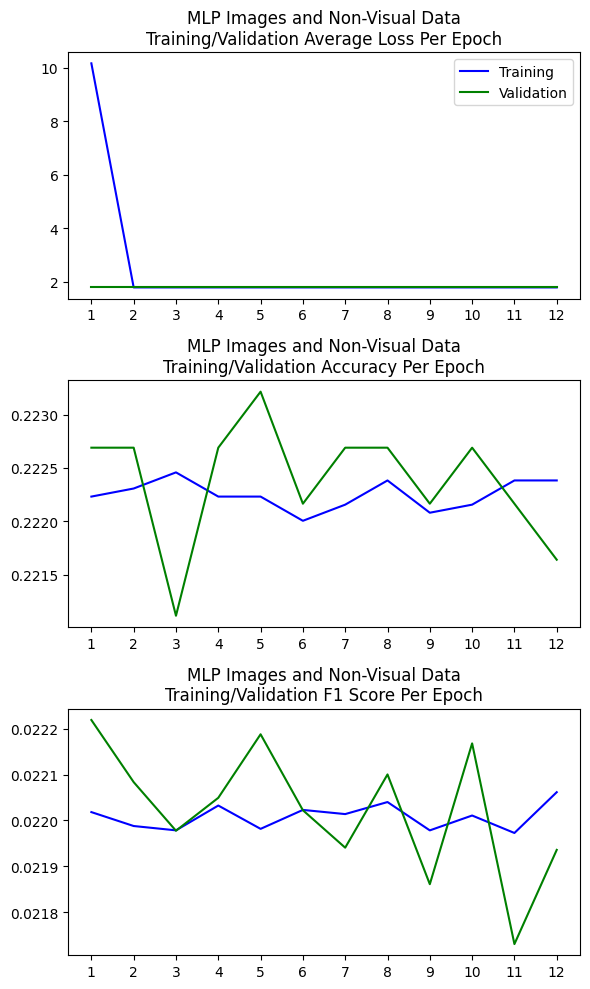

In [21]:
plot_train_metrics('MLP Images and Non-Visual Data', num_epoch, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch)

In [67]:
#Load Trained Model
input_size = 1024*1024
out_size = len(label_names)
model = MLP_w_NVdata(input_size = input_size,out_size=out_size).to(device)
model.load_state_dict(torch.load('MPL_Image_w_NV_Model.pth'))
model.eval()

MLP_w_NVdata(
  (input_fc): Linear(in_features=1048576, out_features=512, bias=True)
  (hidden1_fc): Linear(in_features=512, out_features=256, bias=True)
  (hidden2_fc): Linear(in_features=256, out_features=128, bias=True)
  (hidden3_fc): Linear(in_features=131, out_features=6, bias=True)
)

In [68]:
#Eval Trained Model
model = model
test_dataloader = test_dataloader
include_non_image_data = True

truths, predictions = model_eval(model, test_dataloader, include_non_image_data)

100%|██████████| 146/146 [01:18<00:00,  1.85it/s]


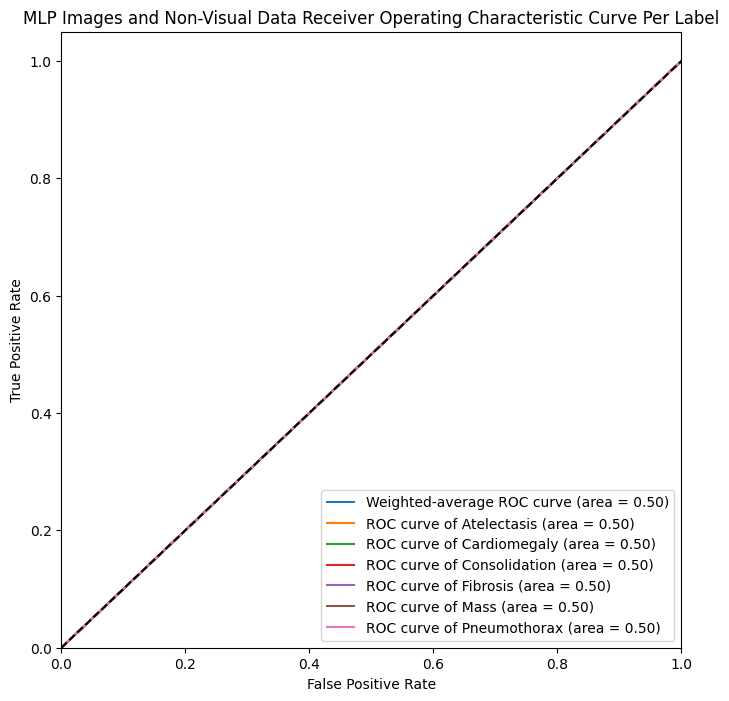

In [69]:
title = 'MLP Images and Non-Visual Data Receiver Operating Characteristic Curve Per Label'
multilabel_ROC_plot(truths, predictions, title, label_names)

In [70]:
truths, predictions = predictions_w_thresholds(truths, predictions,0.5)

print(classification_report(truths, predictions,target_names=label_names, zero_division = 0))

               precision    recall  f1-score   support

  Atelectasis       0.00      0.00      0.00       850
 Cardiomegaly       0.00      0.00      0.00       227
Consolidation       0.00      0.00      0.00       245
     Fibrosis       0.00      0.00      0.00       144
         Mass       0.00      0.00      0.00       446
 Pneumothorax       0.00      0.00      0.00       424

    micro avg       0.00      0.00      0.00      2336
    macro avg       0.00      0.00      0.00      2336
 weighted avg       0.00      0.00      0.00      2336
  samples avg       0.00      0.00      0.00      2336



---
## CNN - Images Only

In [71]:
class CNN_Image_Only(nn.Module):
    def __init__(self, input_channel, out_size, kernel_size = 3):
        super(CNN_Image_Only,self).__init__()
        self.conv1 = nn.Conv2d(input_channel,16,kernel_size, stride = 2)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,kernel_size, stride = 2)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64,kernel_size, padding = 1, stride = 3)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64,128,kernel_size, padding = 1, stride = 3)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128,256,kernel_size)
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm2d(256)
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(256, out_size)
        #self.sigm = nn.Sigmoid()
        
    def forward(self,x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.relu5(self.bn5(self.conv5(x)))
        x = self.avg(x)
        x = self.linear(x.view(-1,256))
    
        return x

In [32]:
input_channel = 1
out_size = len(label_names)

model = CNN_Image_Only(input_channel = input_channel, out_size=out_size).to(device)
input_shape = (1,1024,1024)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 511, 511]             160
       BatchNorm2d-2         [-1, 16, 511, 511]              32
              ReLU-3         [-1, 16, 511, 511]               0
            Conv2d-4         [-1, 32, 255, 255]           4,640
       BatchNorm2d-5         [-1, 32, 255, 255]              64
              ReLU-6         [-1, 32, 255, 255]               0
            Conv2d-7           [-1, 64, 85, 85]          18,496
       BatchNorm2d-8           [-1, 64, 85, 85]             128
              ReLU-9           [-1, 64, 85, 85]               0
           Conv2d-10          [-1, 128, 29, 29]          73,856
      BatchNorm2d-11          [-1, 128, 29, 29]             256
             ReLU-12          [-1, 128, 29, 29]               0
           Conv2d-13          [-1, 256, 27, 27]         295,168
      BatchNorm2d-14          [-1, 256,

In [33]:
#Set Parameters for Training CNN Model Only Images
input_channel = 1
out_size = len(label_names)
model = CNN_Image_Only(input_channel = input_channel, out_size=out_size).to(device)
train_dataloader = train_dataloader
validation_dataloader = validation_dataloader
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
num_epoch = 12
threshold = 0.5
include_non_image_data = False
model_file = 'CNN_ImageOnly_Model.pth'

model, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch = train_model(model,
                                                                                                                          train_dataloader,
                                                                                                                          validation_dataloader,
                                                                                                                          optimizer,
                                                                                                                          loss_fn,
                                                                                                                          num_epoch,
                                                                                                                          threshold,
                                                                                                                          include_non_image_data, model_file)

************************************Epoch: 1************************************
Training Phase:


100%|██████████| 826/826 [08:21<00:00,  1.65it/s]


Train set:
	 Average Accuracy For Epoch: 0.24326573849878935 
	 Average Cross Entropy Loss for Epoch: 1.7608005251491907
	 Average F1 for Epoch: 0.01913770003472713
Validation Phase:


100%|██████████| 119/119 [01:05<00:00,  1.82it/s]


Validation set: 
	 Average Accuracy: 0.2505252100840336 
	 Average Cross Entropy Loss: 1.7270780861878596
	 Average F1 for Epoch: 0.02012306809756664 
Time elapse: 00:09:27
************************************Epoch: 2************************************
Training Phase:


100%|██████████| 826/826 [06:49<00:00,  2.02it/s]


Train set:
	 Average Accuracy For Epoch: 0.27602905569007263 
	 Average Cross Entropy Loss for Epoch: 1.7097782432022741
	 Average F1 for Epoch: 0.020045917838907395
Validation Phase:


100%|██████████| 119/119 [01:04<00:00,  1.84it/s]


Validation set: 
	 Average Accuracy: 0.1948529411764706 
	 Average Cross Entropy Loss: 1.8645802395684379
	 Average F1 for Epoch: 0.01642586406048777 
Time elapse: 00:17:21
************************************Epoch: 3************************************
Training Phase:


100%|██████████| 826/826 [06:34<00:00,  2.10it/s]


Train set:
	 Average Accuracy For Epoch: 0.29199455205811137 
	 Average Cross Entropy Loss for Epoch: 1.690148384172749
	 Average F1 for Epoch: 0.02058744063942599
Validation Phase:


100%|██████████| 119/119 [00:59<00:00,  2.01it/s]


Validation set: 
	 Average Accuracy: 0.2857142857142857 
	 Average Cross Entropy Loss: 1.6948056271096237
	 Average F1 for Epoch: 0.02080722294745404 
Time elapse: 00:24:55
************************************Epoch: 4************************************
Training Phase:


100%|██████████| 826/826 [05:33<00:00,  2.48it/s]


Train set:
	 Average Accuracy For Epoch: 0.28586561743341404 
	 Average Cross Entropy Loss for Epoch: 1.6841292965787376
	 Average F1 for Epoch: 0.02000322000157873
Validation Phase:


100%|██████████| 119/119 [00:52<00:00,  2.27it/s]


Validation set: 
	 Average Accuracy: 0.296218487394958 
	 Average Cross Entropy Loss: 1.6649794588569833
	 Average F1 for Epoch: 0.020413309886806088 
Time elapse: 00:31:21
************************************Epoch: 5************************************
Training Phase:


100%|██████████| 826/826 [05:05<00:00,  2.70it/s]


Train set:
	 Average Accuracy For Epoch: 0.30273910411622273 
	 Average Cross Entropy Loss for Epoch: 1.6707642336734558
	 Average F1 for Epoch: 0.0208538321949952
Validation Phase:


100%|██████████| 119/119 [00:36<00:00,  3.26it/s]


Validation set: 
	 Average Accuracy: 0.3019957983193277 
	 Average Cross Entropy Loss: 1.7192955578074736
	 Average F1 for Epoch: 0.021617930024573934 
Time elapse: 00:37:03
************************************Epoch: 6************************************
Training Phase:


100%|██████████| 826/826 [04:56<00:00,  2.79it/s]


Train set:
	 Average Accuracy For Epoch: 0.30546307506053266 
	 Average Cross Entropy Loss for Epoch: 1.666516924885803
	 Average F1 for Epoch: 0.020977682709753673
Validation Phase:


100%|██████████| 119/119 [00:42<00:00,  2.79it/s]


Validation set: 
	 Average Accuracy: 0.24317226890756302 
	 Average Cross Entropy Loss: 1.7354257988328694
	 Average F1 for Epoch: 0.017117633766793428 
Time elapse: 00:42:41
************************************Epoch: 7************************************
Training Phase:


100%|██████████| 826/826 [04:57<00:00,  2.78it/s]


Train set:
	 Average Accuracy For Epoch: 0.31469430992736075 
	 Average Cross Entropy Loss for Epoch: 1.656296395360702
	 Average F1 for Epoch: 0.02135915328385909
Validation Phase:


100%|██████████| 119/119 [00:40<00:00,  2.94it/s]


Validation set: 
	 Average Accuracy: 0.296218487394958 
	 Average Cross Entropy Loss: 1.6618144361912703
	 Average F1 for Epoch: 0.021250178757400387 
Time elapse: 00:48:19
************************************Epoch: 8************************************
Training Phase:


100%|██████████| 826/826 [04:48<00:00,  2.86it/s]


Train set:
	 Average Accuracy For Epoch: 0.32180690072639223 
	 Average Cross Entropy Loss for Epoch: 1.6470763990723192
	 Average F1 for Epoch: 0.021866560483842012
Validation Phase:


100%|██████████| 119/119 [00:42<00:00,  2.83it/s]


Validation set: 
	 Average Accuracy: 0.25 
	 Average Cross Entropy Loss: 1.7958764328676111
	 Average F1 for Epoch: 0.019111934254377162 
Time elapse: 00:53:50
************************************Epoch: 9************************************
Training Phase:


100%|██████████| 826/826 [04:53<00:00,  2.82it/s]


Train set:
	 Average Accuracy For Epoch: 0.3298274818401937 
	 Average Cross Entropy Loss for Epoch: 1.6360598034777885
	 Average F1 for Epoch: 0.02224423615664928
Validation Phase:


100%|██████████| 119/119 [00:44<00:00,  2.66it/s]


Validation set: 
	 Average Accuracy: 0.32037815126050423 
	 Average Cross Entropy Loss: 1.6490589450387394
	 Average F1 for Epoch: 0.022507882290016656 
Time elapse: 00:59:28
***********************************Epoch: 10************************************
Training Phase:


100%|██████████| 826/826 [04:48<00:00,  2.86it/s]


Train set:
	 Average Accuracy For Epoch: 0.33277845036319614 
	 Average Cross Entropy Loss for Epoch: 1.6287361112114305
	 Average F1 for Epoch: 0.02220442452573906
Validation Phase:


100%|██████████| 119/119 [00:40<00:00,  2.93it/s]


Validation set: 
	 Average Accuracy: 0.30934873949579833 
	 Average Cross Entropy Loss: 1.6605361690040397
	 Average F1 for Epoch: 0.02293450797422699 
Time elapse: 01:04:58
***********************************Epoch: 11************************************
Training Phase:


100%|██████████| 826/826 [04:55<00:00,  2.80it/s]


Train set:
	 Average Accuracy For Epoch: 0.33936138014527845 
	 Average Cross Entropy Loss for Epoch: 1.6154967086078469
	 Average F1 for Epoch: 0.022717224161225028
Validation Phase:


100%|██████████| 119/119 [00:43<00:00,  2.71it/s]


Validation set: 
	 Average Accuracy: 0.29096638655462187 
	 Average Cross Entropy Loss: 1.722623530556174
	 Average F1 for Epoch: 0.019531600143913995 
Time elapse: 01:10:37
***********************************Epoch: 12************************************
Training Phase:


100%|██████████| 826/826 [04:54<00:00,  2.81it/s]


Train set:
	 Average Accuracy For Epoch: 0.3522245762711864 
	 Average Cross Entropy Loss for Epoch: 1.6012815199521784
	 Average F1 for Epoch: 0.023360587190883575
Validation Phase:


100%|██████████| 119/119 [00:41<00:00,  2.88it/s]

Validation set: 
	 Average Accuracy: 0.30619747899159666 
	 Average Cross Entropy Loss: 1.6535855491622156
	 Average F1 for Epoch: 0.020731717621489155 
Time elapse: 01:16:13


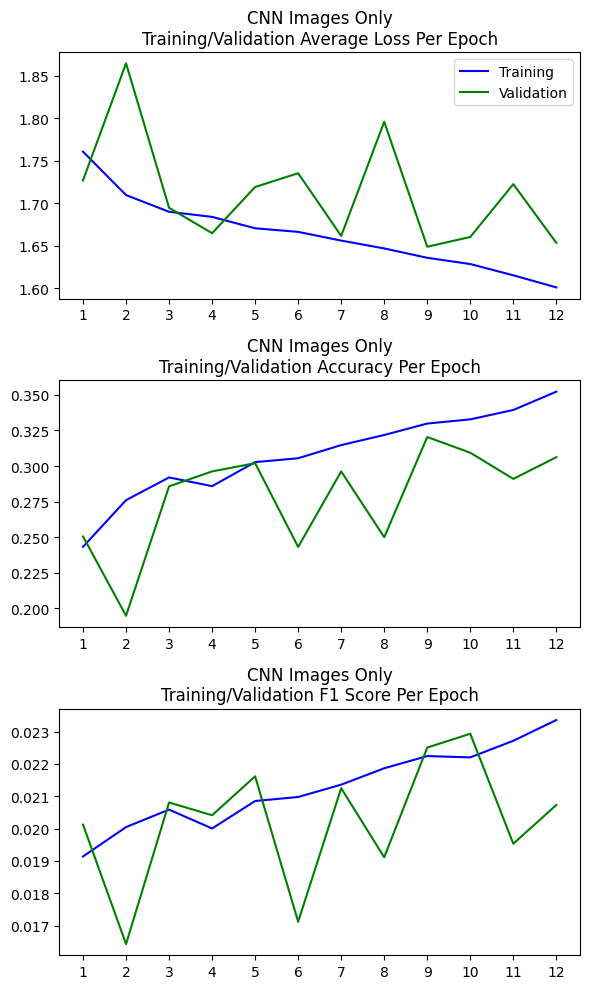

In [34]:
plot_train_metrics('CNN Images Only', num_epoch, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch)

In [73]:
#Load Trained Model
input_channel = 1
out_size = len(label_names)
model = CNN_Image_Only(input_channel = input_channel, out_size=out_size).to(device)
model.load_state_dict(torch.load('CNN_ImageOnly_Model.pth'))
model.eval()

CNN_Image_Only(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
  (relu1): ReLU()
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (relu2): ReLU()
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (relu4): ReLU()
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (relu5): ReLU()
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg): AdaptiveAvgPool2d(output_size=1)
  (linear): Linear(in_features=256, out_features=6, bias=True)
)

In [74]:
#Eval Trained Model
test_dataloader = test_dataloader
threshold = 0.1
include_non_image_data = False

truths, predictions = model_eval(model, test_dataloader, include_non_image_data)

100%|██████████| 146/146 [00:36<00:00,  4.06it/s]


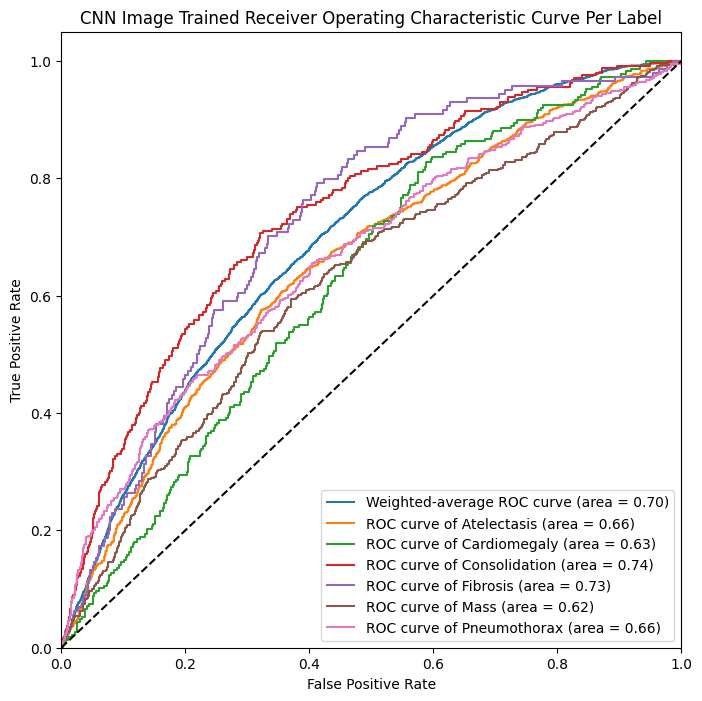

In [75]:
title = 'CNN Image Trained Receiver Operating Characteristic Curve Per Label'
multilabel_ROC_plot(truths, predictions, title, label_names)

In [76]:
truths, predictions = predictions_w_thresholds(truths, predictions,0.5)

print(classification_report(truths, predictions,target_names=label_names, zero_division = 0))

               precision    recall  f1-score   support

  Atelectasis       0.52      0.48      0.50       850
 Cardiomegaly       0.14      0.22      0.17       227
Consolidation       0.33      0.27      0.30       245
     Fibrosis       0.13      0.47      0.20       144
         Mass       0.33      0.08      0.13       446
 Pneumothorax       0.42      0.24      0.30       424

    micro avg       0.33      0.31      0.32      2336
    macro avg       0.31      0.29      0.27      2336
 weighted avg       0.38      0.31      0.32      2336
  samples avg       0.24      0.31      0.26      2336



---
## CNN Images and Non Image Data

In [77]:
class CNN_w_NVdata(nn.Module):
    def __init__(self, input_channel, out_size, kernel_size = 3):
        super(CNN_w_NVdata,self).__init__()
        self.conv1 = nn.Conv2d(input_channel,16,kernel_size, stride = 2)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,kernel_size, stride = 2)
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,64,kernel_size, padding = 1, stride = 3)
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64,128,kernel_size, padding = 1, stride = 3)
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128,256,kernel_size)
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm2d(256)
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.bn6 = nn.BatchNorm1d(num_features=259)
        self.linear = nn.Linear(259, out_size)
        #self.sigm = nn.Sigmoid()
        
    def forward(self,x,non_visual_data):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.relu5(self.bn5(self.conv5(x)))
        x = self.avg(x)
        x = x.view(-1,256)
        
        z = non_visual_data.squeeze()
        z = z.view(x.shape[0],-1)
        x = torch.cat((x,z),1)
        
        x = self.bn6(x)
        x = self.linear(x)
        
        return x

In [19]:
#Set Parameters for Training CNN Model Only Images
input_channel = 1
out_size = len(label_names)
model = CNN_w_NVdata(input_channel = input_channel, out_size=out_size).to(device)
train_dataloader = train_dataloader
validation_dataloader = validation_dataloader
#loss_fn = nn.BCELoss()
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
num_epoch = 12
threshold = 0.5
include_non_image_data = True
model_file = 'CNN_Image_w_NV_Model.pth'

model, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch = train_model(model,
                                                                                                                          train_dataloader,
                                                                                                                          validation_dataloader,
                                                                                                                          optimizer,
                                                                                                                          loss_fn,
                                                                                                                          num_epoch,
                                                                                                                          threshold,
                                                                                                                          include_non_image_data, model_file)

************************************Epoch: 1************************************
Training Phase:


100%|██████████| 826/826 [07:19<00:00,  1.88it/s]


Train set:
	 Average Accuracy For Epoch: 0.26740314769975787 
	 Average Cross Entropy Loss for Epoch: 1.775466118973046
	 Average F1 for Epoch: 0.018147635301725466
Validation Phase:


100%|██████████| 119/119 [01:02<00:00,  1.90it/s]


Validation set: 
	 Average Accuracy: 0.30462184873949577 
	 Average Cross Entropy Loss: 1.6734178306675758
	 Average F1 for Epoch: 0.019905208769113718 
Time elapse: 00:08:22
************************************Epoch: 2************************************
Training Phase:


100%|██████████| 826/826 [05:30<00:00,  2.50it/s]


Train set:
	 Average Accuracy For Epoch: 0.2899515738498789 
	 Average Cross Entropy Loss for Epoch: 1.6792265651589733
	 Average F1 for Epoch: 0.01991075770549985
Validation Phase:


100%|██████████| 119/119 [00:48<00:00,  2.43it/s]


Validation set: 
	 Average Accuracy: 0.33771008403361347 
	 Average Cross Entropy Loss: 1.6440841350234856
	 Average F1 for Epoch: 0.02416276476053879 
Time elapse: 00:14:41
************************************Epoch: 3************************************
Training Phase:


100%|██████████| 826/826 [05:08<00:00,  2.68it/s]


Train set:
	 Average Accuracy For Epoch: 0.29010290556900725 
	 Average Cross Entropy Loss for Epoch: 1.6808523032047558
	 Average F1 for Epoch: 0.020007622399087807
Validation Phase:


100%|██████████| 119/119 [00:37<00:00,  3.21it/s]


Validation set: 
	 Average Accuracy: 0.2925420168067227 
	 Average Cross Entropy Loss: 1.6655736169895203
	 Average F1 for Epoch: 0.021048992953053305 
Time elapse: 00:20:27
************************************Epoch: 4************************************
Training Phase:


100%|██████████| 826/826 [04:48<00:00,  2.86it/s]


Train set:
	 Average Accuracy For Epoch: 0.2929782082324455 
	 Average Cross Entropy Loss for Epoch: 1.6763622848808621
	 Average F1 for Epoch: 0.01985995778844938
Validation Phase:


100%|██████████| 119/119 [00:43<00:00,  2.73it/s]


Validation set: 
	 Average Accuracy: 0.2972689075630252 
	 Average Cross Entropy Loss: 1.6538517955972367
	 Average F1 for Epoch: 0.020224176468287156 
Time elapse: 00:25:59
************************************Epoch: 5************************************
Training Phase:


100%|██████████| 826/826 [04:53<00:00,  2.82it/s]


Train set:
	 Average Accuracy For Epoch: 0.3075060532687651 
	 Average Cross Entropy Loss for Epoch: 1.6591513542228402
	 Average F1 for Epoch: 0.020347824298237706
Validation Phase:


100%|██████████| 119/119 [00:43<00:00,  2.72it/s]


Validation set: 
	 Average Accuracy: 0.30987394957983194 
	 Average Cross Entropy Loss: 1.6325657267530425
	 Average F1 for Epoch: 0.02143350020162341 
Time elapse: 00:31:36
************************************Epoch: 6************************************
Training Phase:


100%|██████████| 826/826 [04:46<00:00,  2.88it/s]


Train set:
	 Average Accuracy For Epoch: 0.3165102905569007 
	 Average Cross Entropy Loss for Epoch: 1.6511189621528182
	 Average F1 for Epoch: 0.020928778357983464
Validation Phase:


100%|██████████| 119/119 [00:41<00:00,  2.88it/s]


Validation set: 
	 Average Accuracy: 0.2972689075630252 
	 Average Cross Entropy Loss: 1.6762919836685437
	 Average F1 for Epoch: 0.0207060247977396 
Time elapse: 00:37:04
************************************Epoch: 7************************************
Training Phase:


100%|██████████| 826/826 [04:57<00:00,  2.77it/s]


Train set:
	 Average Accuracy For Epoch: 0.3186289346246973 
	 Average Cross Entropy Loss for Epoch: 1.6469814517596155
	 Average F1 for Epoch: 0.02107458734180135
Validation Phase:


100%|██████████| 119/119 [00:54<00:00,  2.18it/s]


Validation set: 
	 Average Accuracy: 0.3130252100840336 
	 Average Cross Entropy Loss: 1.6508239187112375
	 Average F1 for Epoch: 0.021264923328014194 
Time elapse: 00:42:57
************************************Epoch: 8************************************
Training Phase:


100%|██████████| 826/826 [06:45<00:00,  2.04it/s]


Train set:
	 Average Accuracy For Epoch: 0.32589285714285715 
	 Average Cross Entropy Loss for Epoch: 1.6399220806923098
	 Average F1 for Epoch: 0.021492252511151732
Validation Phase:


100%|██████████| 119/119 [00:48<00:00,  2.44it/s]


Validation set: 
	 Average Accuracy: 0.33771008403361347 
	 Average Cross Entropy Loss: 1.6218928749821766
	 Average F1 for Epoch: 0.02220477369998115 
Time elapse: 00:50:31
************************************Epoch: 9************************************
Training Phase:


100%|██████████| 826/826 [05:07<00:00,  2.68it/s]


Train set:
	 Average Accuracy For Epoch: 0.33270278450363194 
	 Average Cross Entropy Loss for Epoch: 1.6339883885141147
	 Average F1 for Epoch: 0.02177517325940642
Validation Phase:


100%|██████████| 119/119 [00:40<00:00,  2.96it/s]


Validation set: 
	 Average Accuracy: 0.3245798319327731 
	 Average Cross Entropy Loss: 1.6820572093755257
	 Average F1 for Epoch: 0.02268773364570647 
Time elapse: 00:56:19
***********************************Epoch: 10************************************
Training Phase:


100%|██████████| 826/826 [04:46<00:00,  2.88it/s]


Train set:
	 Average Accuracy For Epoch: 0.33383777239709445 
	 Average Cross Entropy Loss for Epoch: 1.627579371086333
	 Average F1 for Epoch: 0.021897615427475075
Validation Phase:


100%|██████████| 119/119 [00:42<00:00,  2.81it/s]


Validation set: 
	 Average Accuracy: 0.32983193277310924 
	 Average Cross Entropy Loss: 1.6348568160994714
	 Average F1 for Epoch: 0.021186392562732626 
Time elapse: 01:01:48
***********************************Epoch: 11************************************
Training Phase:


100%|██████████| 826/826 [04:41<00:00,  2.94it/s]


Train set:
	 Average Accuracy For Epoch: 0.344203995157385 
	 Average Cross Entropy Loss for Epoch: 1.6099529625717144
	 Average F1 for Epoch: 0.02250263125527957
Validation Phase:


100%|██████████| 119/119 [00:36<00:00,  3.22it/s]


Validation set: 
	 Average Accuracy: 0.3335084033613445 
	 Average Cross Entropy Loss: 1.6541446447372437
	 Average F1 for Epoch: 0.022010719716208164 
Time elapse: 01:07:06
***********************************Epoch: 12************************************
Training Phase:


100%|██████████| 826/826 [04:39<00:00,  2.95it/s]


Train set:
	 Average Accuracy For Epoch: 0.35199757869249393 
	 Average Cross Entropy Loss for Epoch: 1.5944352572824418
	 Average F1 for Epoch: 0.022622129810734207
Validation Phase:


100%|██████████| 119/119 [00:42<00:00,  2.81it/s]

Validation set: 
	 Average Accuracy: 0.34243697478991597 
	 Average Cross Entropy Loss: 1.6101774317877633
	 Average F1 for Epoch: 0.022427276836579614 
Time elapse: 01:12:28


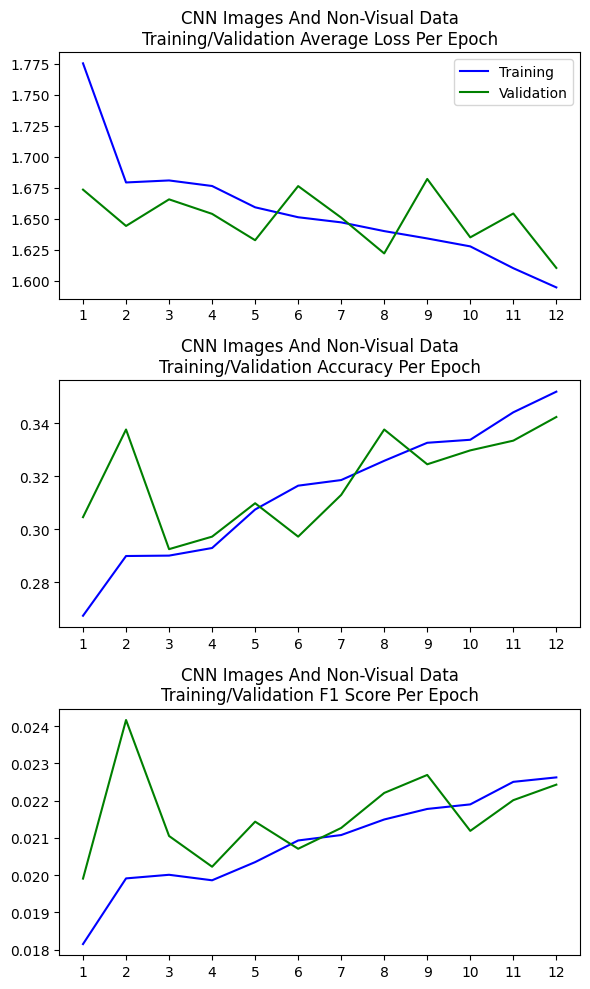

In [20]:
plot_train_metrics('CNN Images And Non-Visual Data', num_epoch, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch)

In [78]:
#Load Trained Model
input_channel = 1
out_size = len(label_names)
model = CNN_w_NVdata(input_channel = input_channel, out_size=out_size).to(device)
model.load_state_dict(torch.load('CNN_Image_w_NV_Model.pth'))
model.eval()

CNN_w_NVdata(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
  (relu1): ReLU()
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (relu2): ReLU()
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (relu3): ReLU()
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (relu4): ReLU()
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (relu5): ReLU()
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avg): AdaptiveAvgPool2d(output_size=1)
  (bn6): BatchNorm1d(259, eps=1e-05, momentum=0.1, affine=True, trac

In [79]:
#Eval Trained Model
model = model
test_dataloader = test_dataloader
include_non_image_data = True

truths, predictions = model_eval(model, test_dataloader, include_non_image_data)

100%|██████████| 146/146 [00:35<00:00,  4.10it/s]


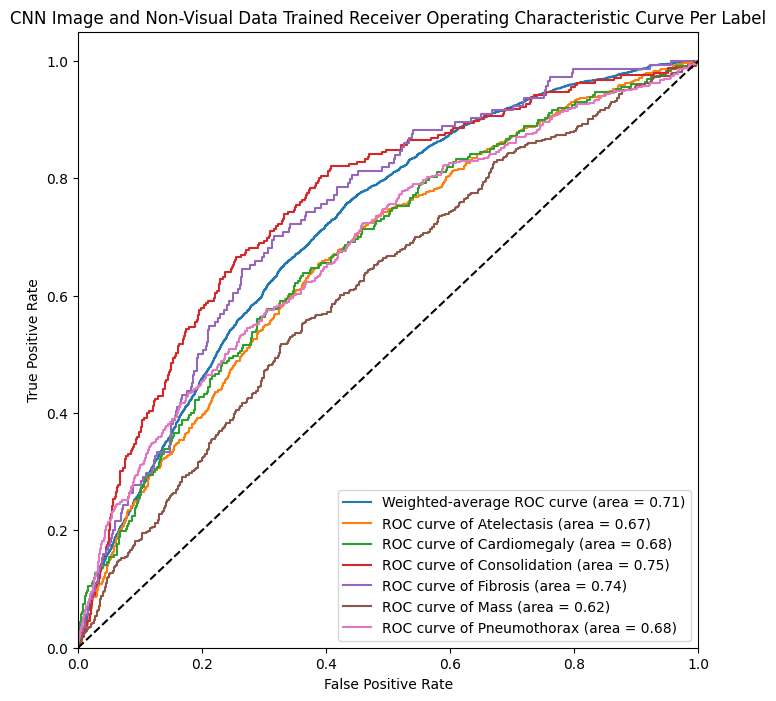

In [80]:
title = 'CNN Image and Non-Visual Data Trained Receiver Operating Characteristic Curve Per Label'
multilabel_ROC_plot(truths, predictions, title, label_names)

In [82]:
truths, predictions = predictions_w_thresholds(truths, predictions,0.5)

print(classification_report(truths, predictions,target_names=label_names, zero_division = 0))

               precision    recall  f1-score   support

  Atelectasis       0.48      0.66      0.56       850
 Cardiomegaly       0.22      0.25      0.23       227
Consolidation       0.21      0.72      0.32       245
     Fibrosis       0.14      0.49      0.22       144
         Mass       0.28      0.37      0.32       446
 Pneumothorax       0.49      0.14      0.21       424

    micro avg       0.31      0.47      0.37      2336
    macro avg       0.30      0.44      0.31      2336
 weighted avg       0.37      0.47      0.37      2336
  samples avg       0.29      0.47      0.34      2336



## Inception Resnet V2 Model - Images Only

In [22]:
model = timm.create_model('inception_resnet_v2', pretrained=True,in_chans = 1, num_classes=6).to(device)

In [18]:
#Set Parameters for Training CNN Model Only Images
train_dataloader = train_dataloader
validation_dataloader = validation_dataloader
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
num_epoch = 6
threshold = 0.5
include_non_image_data = False
model_file = 'Inception_Resnet_v2_ImageOnly_Model.pth'

model, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch = train_model(model,
                                                                                                                          train_dataloader,
                                                                                                                          validation_dataloader,
                                                                                                                          optimizer,
                                                                                                                          loss_fn,
                                                                                                                          num_epoch,
                                                                                                                          threshold,
                                                                                                                          include_non_image_data, model_file)

************************************Epoch: 1************************************
Training Phase:


100%|██████████| 826/826 [1:07:05<00:00,  4.87s/it]


Train set:
	 Average Accuracy For Epoch: 0.3097003631961259 
	 Average Cross Entropy Loss for Epoch: 1.6575194590028204
	 Average F1 for Epoch: 0.02208084347647203
Validation Phase:


100%|██████████| 119/119 [02:51<00:00,  1.44s/it]


Validation set: 
	 Average Accuracy: 0.33035714285714285 
	 Average Cross Entropy Loss: 1.6704451867512293
	 Average F1 for Epoch: 0.02420807310392764 
Time elapse: 01:09:56
************************************Epoch: 2************************************
Training Phase:


100%|██████████| 826/826 [1:06:11<00:00,  4.81s/it]


Train set:
	 Average Accuracy For Epoch: 0.4057203389830508 
	 Average Cross Entropy Loss for Epoch: 1.4960555999244385
	 Average F1 for Epoch: 0.026236713113930273
Validation Phase:


100%|██████████| 119/119 [02:48<00:00,  1.42s/it]


Validation set: 
	 Average Accuracy: 0.3597689075630252 
	 Average Cross Entropy Loss: 1.682669072591958
	 Average F1 for Epoch: 0.02617780690814821 
Time elapse: 02:18:55
************************************Epoch: 3************************************
Training Phase:


100%|██████████| 826/826 [1:05:20<00:00,  4.75s/it]


Train set:
	 Average Accuracy For Epoch: 0.480705205811138 
	 Average Cross Entropy Loss for Epoch: 1.3250154181052063
	 Average F1 for Epoch: 0.030482550128404718
Validation Phase:


100%|██████████| 119/119 [02:53<00:00,  1.46s/it]


Validation set: 
	 Average Accuracy: 0.3429621848739496 
	 Average Cross Entropy Loss: 1.7748976780586885
	 Average F1 for Epoch: 0.025410558110147596 
Time elapse: 03:27:09
************************************Epoch: 4************************************
Training Phase:


100%|██████████| 826/826 [1:06:15<00:00,  4.81s/it]


Train set:
	 Average Accuracy For Epoch: 0.5610623486682809 
	 Average Cross Entropy Loss for Epoch: 1.1554789957353624
	 Average F1 for Epoch: 0.03514650919256988
Validation Phase:


100%|██████████| 119/119 [02:40<00:00,  1.35s/it]


Validation set: 
	 Average Accuracy: 0.38340336134453784 
	 Average Cross Entropy Loss: 2.069213698391153
	 Average F1 for Epoch: 0.026167384203098474 
Time elapse: 04:36:06
************************************Epoch: 5************************************
Training Phase:


100%|██████████| 826/826 [1:06:10<00:00,  4.81s/it]


Train set:
	 Average Accuracy For Epoch: 0.6396791767554479 
	 Average Cross Entropy Loss for Epoch: 0.9538145376319747
	 Average F1 for Epoch: 0.03974844468611493
Validation Phase:


100%|██████████| 119/119 [02:43<00:00,  1.37s/it]


Validation set: 
	 Average Accuracy: 0.42804621848739494 
	 Average Cross Entropy Loss: 1.974019501890455
	 Average F1 for Epoch: 0.028174373624741293 
Time elapse: 05:45:00
************************************Epoch: 6************************************
Training Phase:


100%|██████████| 826/826 [1:06:45<00:00,  4.85s/it]


Train set:
	 Average Accuracy For Epoch: 0.7117887409200968 
	 Average Cross Entropy Loss for Epoch: 0.7704176745821719
	 Average F1 for Epoch: 0.04405522854680124
Validation Phase:


100%|██████████| 119/119 [02:40<00:00,  1.35s/it]


Validation set: 
	 Average Accuracy: 0.4007352941176471 
	 Average Cross Entropy Loss: 1.8399183174141316
	 Average F1 for Epoch: 0.025468015549751373 
Time elapse: 06:54:26


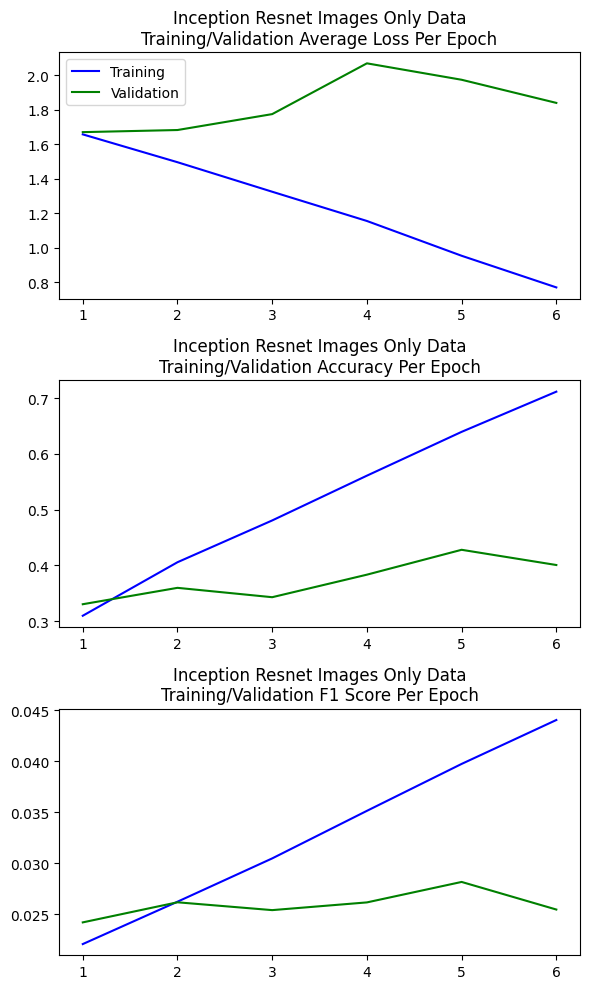

In [19]:
plot_train_metrics('Inception Resnet Images Only Data', num_epoch, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch)

In [93]:
# Load Trained Model
model = timm.create_model('inception_resnet_v2', pretrained=True,in_chans = 1, num_classes=6).to(device)
model.load_state_dict(torch.load('Inception_Resnet_v2_ImageOnly_Model.pth'))

<All keys matched successfully>

In [94]:
#Eval Trained Model
test_dataloader = test_dataloader
include_non_image_data = False

truths, predictions = model_eval(model, test_dataloader, include_non_image_data)

100%|██████████| 146/146 [02:34<00:00,  1.06s/it]


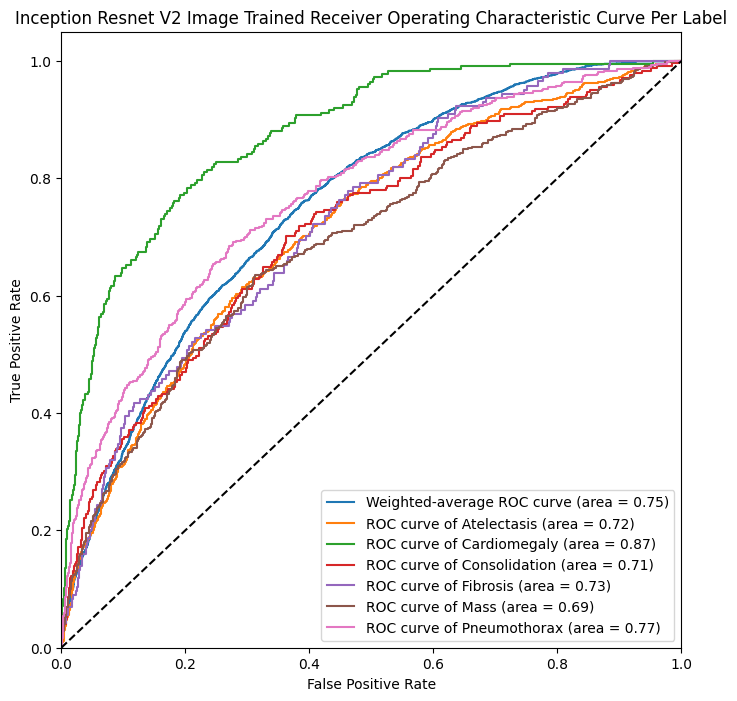

In [95]:
title = 'Inception Resnet V2 Image Trained Receiver Operating Characteristic Curve Per Label'
multilabel_ROC_plot(truths, predictions, title, label_names)

In [96]:
truths, predictions = predictions_w_thresholds(truths, predictions,0.5)

print(classification_report(truths, predictions,target_names=label_names, zero_division = 0))

               precision    recall  f1-score   support

  Atelectasis       0.62      0.38      0.47       850
 Cardiomegaly       0.46      0.61      0.52       227
Consolidation       0.20      0.56      0.29       245
     Fibrosis       0.18      0.42      0.26       144
         Mass       0.35      0.51      0.41       446
 Pneumothorax       0.51      0.39      0.44       424

    micro avg       0.37      0.45      0.41      2336
    macro avg       0.39      0.48      0.40      2336
 weighted avg       0.46      0.45      0.43      2336
  samples avg       0.32      0.45      0.36      2336



## Inception Resnet V2 Model - Images and Non-Visual

In [88]:
class NV_Data_added_Inception_Resnet_v2(nn.Module):
    def __init__(self, modified_model):
        super().__init__()
        
        self.modified_model = modified_model
        self.bn = nn.BatchNorm1d(num_features=1539)
        self.linear = nn.Linear(1539, 6)
    
    def forward(self, x, non_visual_data):
        x = self.modified_model(x)
        
        z = non_visual_data.squeeze()
        z = z.view(x.shape[0],-1)
        
        x = torch.cat((x,z),1)
        x = self.bn(x)
        x = self.linear(x)
        
        return x

In [18]:
#Adapt Pre-Trained Model
pretrained_model = timm.create_model('inception_resnet_v2', pretrained=True,in_chans = 1)
modified_model = torch.nn.Sequential(*(list(pretrained_model.children())[:-2]))
model = NV_Data_added_Inception_Resnet_v2(modified_model).to(device)

In [20]:
#Set Parameters for Training CNN Model Only Images
train_dataloader = train_dataloader
validation_dataloader = validation_dataloader
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
num_epoch = 6
threshold = 0.5
include_non_image_data = True
model_file = 'Inception_Resnet_v2_Image_w_NV_Model.pth'

model, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch = train_model(model,
                                                                                                                          train_dataloader,
                                                                                                                          validation_dataloader,
                                                                                                                          optimizer,
                                                                                                                          loss_fn,
                                                                                                                          num_epoch,
                                                                                                                          threshold,
                                                                                                                          include_non_image_data, model_file)

************************************Epoch: 1************************************
Training Phase:


100%|██████████| 826/826 [1:08:39<00:00,  4.99s/it]


Train set:
	 Average Accuracy For Epoch: 0.32369854721549635 
	 Average Cross Entropy Loss for Epoch: 1.7645719561536433
	 Average F1 for Epoch: 0.020688274431634197
Validation Phase:


100%|██████████| 119/119 [02:59<00:00,  1.51s/it]


Validation set: 
	 Average Accuracy: 0.28886554621848737 
	 Average Cross Entropy Loss: 6.166285808346853
	 Average F1 for Epoch: 0.01981405756247034 
Time elapse: 01:11:39
************************************Epoch: 2************************************
Training Phase:


100%|██████████| 826/826 [1:04:48<00:00,  4.71s/it]


Train set:
	 Average Accuracy For Epoch: 0.4194915254237288 
	 Average Cross Entropy Loss for Epoch: 1.5784103531237088
	 Average F1 for Epoch: 0.026353357420340617
Validation Phase:


100%|██████████| 119/119 [02:00<00:00,  1.01s/it]


Validation set: 
	 Average Accuracy: 0.4269957983193277 
	 Average Cross Entropy Loss: 1.5526511453780807
	 Average F1 for Epoch: 0.02818086751746153 
Time elapse: 02:18:28
************************************Epoch: 3************************************
Training Phase:


100%|██████████| 826/826 [1:03:24<00:00,  4.61s/it]


Train set:
	 Average Accuracy For Epoch: 0.43954297820823246 
	 Average Cross Entropy Loss for Epoch: 1.5585870971546911
	 Average F1 for Epoch: 0.027322922256147176
Validation Phase:


100%|██████████| 119/119 [02:06<00:00,  1.06s/it]


Validation set: 
	 Average Accuracy: 0.40441176470588236 
	 Average Cross Entropy Loss: 2.269154444462111
	 Average F1 for Epoch: 0.026296803959783233 
Time elapse: 03:23:59
************************************Epoch: 4************************************
Training Phase:


100%|██████████| 826/826 [1:09:01<00:00,  5.01s/it]


Train set:
	 Average Accuracy For Epoch: 0.48078087167070216 
	 Average Cross Entropy Loss for Epoch: 1.4556235021598114
	 Average F1 for Epoch: 0.029643825700925046
Validation Phase:


100%|██████████| 119/119 [03:08<00:00,  1.58s/it]


Validation set: 
	 Average Accuracy: 0.46271008403361347 
	 Average Cross Entropy Loss: 1.774771556633861
	 Average F1 for Epoch: 0.030870678834885083 
Time elapse: 04:36:09
************************************Epoch: 5************************************
Training Phase:


100%|██████████| 826/826 [1:10:42<00:00,  5.14s/it]


Train set:
	 Average Accuracy For Epoch: 0.5447185230024213 
	 Average Cross Entropy Loss for Epoch: 1.2872605165759818
	 Average F1 for Epoch: 0.03351428326222137
Validation Phase:


100%|██████████| 119/119 [03:19<00:00,  1.67s/it]


Validation set: 
	 Average Accuracy: 0.4275210084033613 
	 Average Cross Entropy Loss: 1.926123574501326
	 Average F1 for Epoch: 0.02856864912125895 
Time elapse: 05:50:10
************************************Epoch: 6************************************
Training Phase:


100%|██████████| 826/826 [1:10:11<00:00,  5.10s/it]


Train set:
	 Average Accuracy For Epoch: 0.6086561743341404 
	 Average Cross Entropy Loss for Epoch: 1.1145369914195729
	 Average F1 for Epoch: 0.03752806845175942
Validation Phase:


100%|██████████| 119/119 [03:41<00:00,  1.86s/it]


Validation set: 
	 Average Accuracy: 0.47058823529411764 
	 Average Cross Entropy Loss: 1.6477174778946309
	 Average F1 for Epoch: 0.030267063301136304 
Time elapse: 07:04:03


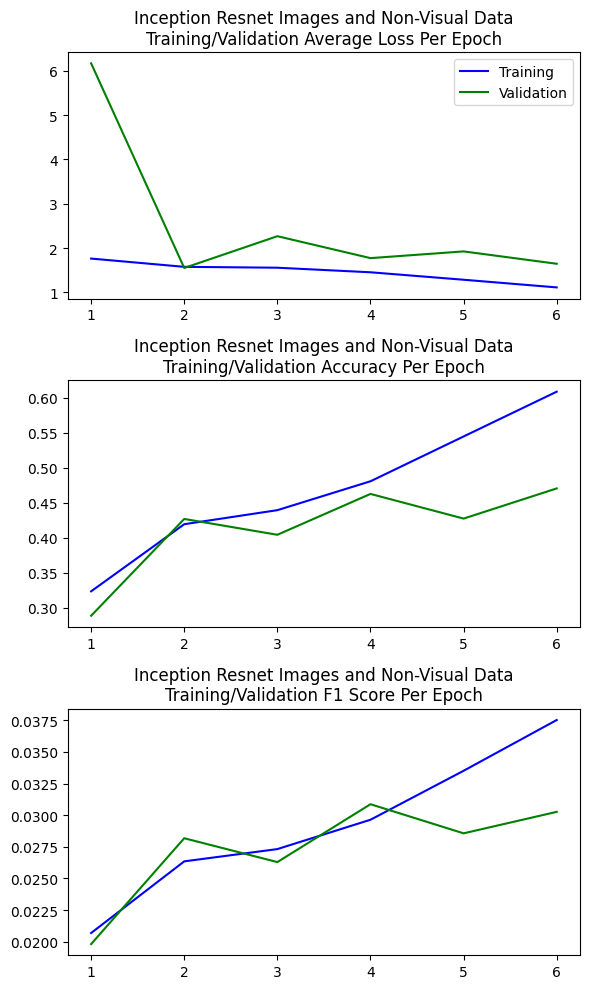

In [21]:
plot_train_metrics('Inception Resnet Images and Non-Visual Data', num_epoch, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch)

In [89]:
# Load Trained Model
pretrained_model = timm.create_model('inception_resnet_v2', pretrained=True,in_chans = 1, num_classes=6)
modified_model = torch.nn.Sequential(*(list(pretrained_model.children())[:-2]))
model = NV_Data_added_Inception_Resnet_v2(modified_model).to(device)
model.load_state_dict(torch.load('Inception_Resnet_v2_Image_w_NV_Model.pth'))

<All keys matched successfully>

In [90]:
#Eval Trained Model
test_dataloader = test_dataloader
include_non_image_data = True

truths, predictions = model_eval(model, test_dataloader, include_non_image_data)

100%|██████████| 146/146 [02:29<00:00,  1.03s/it]


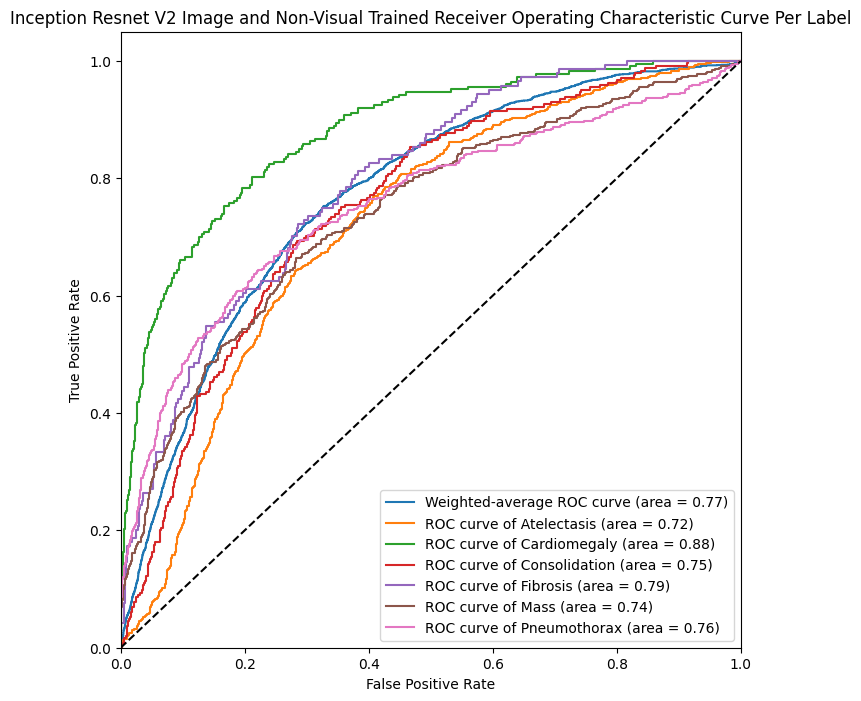

In [91]:
title = 'Inception Resnet V2 Image and Non-Visual Trained Receiver Operating Characteristic Curve Per Label'
multilabel_ROC_plot(truths, predictions, title, label_names)

In [92]:
truths, predictions = predictions_w_thresholds(truths, predictions,0.5)

print(classification_report(truths, predictions,target_names=label_names, zero_division = 0))

               precision    recall  f1-score   support

  Atelectasis       0.47      0.86      0.61       850
 Cardiomegaly       0.43      0.64      0.51       227
Consolidation       0.16      0.89      0.27       245
     Fibrosis       0.15      0.62      0.24       144
         Mass       0.26      0.86      0.40       446
 Pneumothorax       0.51      0.48      0.50       424

    micro avg       0.31      0.76      0.44      2336
    macro avg       0.33      0.73      0.42      2336
 weighted avg       0.38      0.76      0.48      2336
  samples avg       0.34      0.76      0.45      2336



## CRNN - Images Only

In [97]:
class CRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Convolutional layers
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        
        # Reshape for RNN
        batch_size, channels, height, width = x.size()
        #x = x.view(x.shape[0],-1)
        x = x.view(batch_size, channels * height, width)  # Flatten
        #print(x.shape)
        
        # RNN layer
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        x, (hn, cn) = self.rnn(x, (h_0, c_0))
        
        # Fully connected layer
        x = self.fc(x[:, -1, :])  # Get output from last time step
        x = F.softmax(x, dim = 1)

        return x

In [45]:
# Set Parameters for CRNN Model
input_size = 256  
hidden_size = 128
num_layers = 2
num_classes = len(label_names)

# Create CRNN model instance
model = CRNN(input_size, hidden_size, num_layers, num_classes).to(device)

# Print model summary
#input_shape = (1, 1024, 1024)  
#summary(model, input_shape)

# Set Parameters for Training CRNN Model
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
num_epoch = 12
threshold = 0.5
include_non_image_data = False
model_file = 'CRNN_Model.pth'

# Train CRNN model
model, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch = train_model(
    model,
    train_dataloader,
    validation_dataloader,
    optimizer,
    loss_fn,
    num_epoch,
    threshold,
    include_non_image_data,
    model_file
)

************************************Epoch: 1************************************
Training Phase:


100%|██████████| 826/826 [09:36<00:00,  1.43it/s]


Train set:
	 Average Accuracy For Epoch: 0.2219279661016949 
	 Average Cross Entropy Loss for Epoch: 1.8213894393195829
	 Average F1 for Epoch: 0.021971460552713536
Validation Phase:


100%|██████████| 119/119 [01:22<00:00,  1.44it/s]


Validation set: 
	 Average Accuracy: 0.22216386554621848 
	 Average Cross Entropy Loss: 1.821428110619553
	 Average F1 for Epoch: 0.021900972553219968 
Time elapse: 00:10:58
************************************Epoch: 2************************************
Training Phase:


100%|██████████| 826/826 [06:34<00:00,  2.09it/s]


Train set:
	 Average Accuracy For Epoch: 0.2221549636803874 
	 Average Cross Entropy Loss for Epoch: 1.821437011619457
	 Average F1 for Epoch: 0.021973490563347985
Validation Phase:


100%|██████████| 119/119 [00:37<00:00,  3.15it/s]


Validation set: 
	 Average Accuracy: 0.22321428571428573 
	 Average Cross Entropy Loss: 1.820377689449727
	 Average F1 for Epoch: 0.022136048054320838 
Time elapse: 00:18:11
************************************Epoch: 3************************************
Training Phase:


100%|██████████| 826/826 [05:52<00:00,  2.34it/s]


Train set:
	 Average Accuracy For Epoch: 0.2221549636803874 
	 Average Cross Entropy Loss for Epoch: 1.8214370119080994
	 Average F1 for Epoch: 0.0219505976746866
Validation Phase:


100%|██████████| 119/119 [00:37<00:00,  3.16it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.8209029005355193
	 Average F1 for Epoch: 0.022123074195720436 
Time elapse: 00:24:41
************************************Epoch: 4************************************
Training Phase:


100%|██████████| 826/826 [05:52<00:00,  2.34it/s]


Train set:
	 Average Accuracy For Epoch: 0.22223062953995157 
	 Average Cross Entropy Loss for Epoch: 1.8213613451826083
	 Average F1 for Epoch: 0.02200934953990287
Validation Phase:


100%|██████████| 119/119 [00:37<00:00,  3.15it/s]


Validation set: 
	 Average Accuracy: 0.22216386554621848 
	 Average Cross Entropy Loss: 1.8214281096177942
	 Average F1 for Epoch: 0.021927906410588956 
Time elapse: 00:31:12
************************************Epoch: 5************************************
Training Phase:


100%|██████████| 826/826 [05:52<00:00,  2.34it/s]


Train set:
	 Average Accuracy For Epoch: 0.2223819612590799 
	 Average Cross Entropy Loss for Epoch: 1.821210013752122
	 Average F1 for Epoch: 0.02202672934379758
Validation Phase:


100%|██████████| 119/119 [00:37<00:00,  3.17it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.820902898532002
	 Average F1 for Epoch: 0.02214404515094745 
Time elapse: 00:37:42
************************************Epoch: 6************************************
Training Phase:


100%|██████████| 826/826 [05:52<00:00,  2.34it/s]


Train set:
	 Average Accuracy For Epoch: 0.22223062953995157 
	 Average Cross Entropy Loss for Epoch: 1.8213613460485352
	 Average F1 for Epoch: 0.02198396105206175
Validation Phase:


100%|██████████| 119/119 [00:37<00:00,  3.15it/s]


Validation set: 
	 Average Accuracy: 0.22216386554621848 
	 Average Cross Entropy Loss: 1.821428110619553
	 Average F1 for Epoch: 0.022011301824655317 
Time elapse: 00:44:12
************************************Epoch: 7************************************
Training Phase:


100%|██████████| 826/826 [05:52<00:00,  2.34it/s]


Train set:
	 Average Accuracy For Epoch: 0.2223819612590799 
	 Average Cross Entropy Loss for Epoch: 1.8212100140407645
	 Average F1 for Epoch: 0.02197815564533587
Validation Phase:


100%|██████████| 119/119 [00:37<00:00,  3.15it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.8209028995337606
	 Average F1 for Epoch: 0.021923525856211837 
Time elapse: 00:50:43
************************************Epoch: 8************************************
Training Phase:


100%|██████████| 826/826 [05:52<00:00,  2.34it/s]


Train set:
	 Average Accuracy For Epoch: 0.22207929782082325 
	 Average Cross Entropy Loss for Epoch: 1.821512678200627
	 Average F1 for Epoch: 0.022005539130355592
Validation Phase:


100%|██████████| 119/119 [00:37<00:00,  3.16it/s]


Validation set: 
	 Average Accuracy: 0.22163865546218486 
	 Average Cross Entropy Loss: 1.8219533207035865
	 Average F1 for Epoch: 0.021885865544347897 
Time elapse: 00:57:13
************************************Epoch: 9************************************
Training Phase:


100%|██████████| 826/826 [06:18<00:00,  2.18it/s]


Train set:
	 Average Accuracy For Epoch: 0.22207929782082325 
	 Average Cross Entropy Loss for Epoch: 1.8215126776233423
	 Average F1 for Epoch: 0.02199790435202964
Validation Phase:


100%|██████████| 119/119 [00:37<00:00,  3.16it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.8209029005355193
	 Average F1 for Epoch: 0.021858287199002818 
Time elapse: 01:04:09
***********************************Epoch: 10************************************
Training Phase:


100%|██████████| 826/826 [05:52<00:00,  2.34it/s]


Train set:
	 Average Accuracy For Epoch: 0.22230629539951574 
	 Average Cross Entropy Loss for Epoch: 1.8212856799003287
	 Average F1 for Epoch: 0.021997332325264185
Validation Phase:


100%|██████████| 119/119 [00:37<00:00,  3.16it/s]


Validation set: 
	 Average Accuracy: 0.22321428571428573 
	 Average Cross Entropy Loss: 1.820377689449727
	 Average F1 for Epoch: 0.022003020545214354 
Time elapse: 01:10:40
***********************************Epoch: 11************************************
Training Phase:


100%|██████████| 826/826 [05:53<00:00,  2.34it/s]


Train set:
	 Average Accuracy For Epoch: 0.22230629539951574 
	 Average Cross Entropy Loss for Epoch: 1.8212856797560075
	 Average F1 for Epoch: 0.02198725061631049
Validation Phase:


100%|██████████| 119/119 [00:37<00:00,  3.15it/s]


Validation set: 
	 Average Accuracy: 0.22321428571428573 
	 Average Cross Entropy Loss: 1.8203776904514857
	 Average F1 for Epoch: 0.02213948608441118 
Time elapse: 01:17:11
***********************************Epoch: 12************************************
Training Phase:


100%|██████████| 826/826 [05:53<00:00,  2.34it/s]


Train set:
	 Average Accuracy For Epoch: 0.22207929782082325 
	 Average Cross Entropy Loss for Epoch: 1.8215126777676636
	 Average F1 for Epoch: 0.021955432173633598
Validation Phase:


100%|██████████| 119/119 [00:37<00:00,  3.15it/s]

Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.8209028995337606
	 Average F1 for Epoch: 0.022162690730872854 
Time elapse: 01:23:42


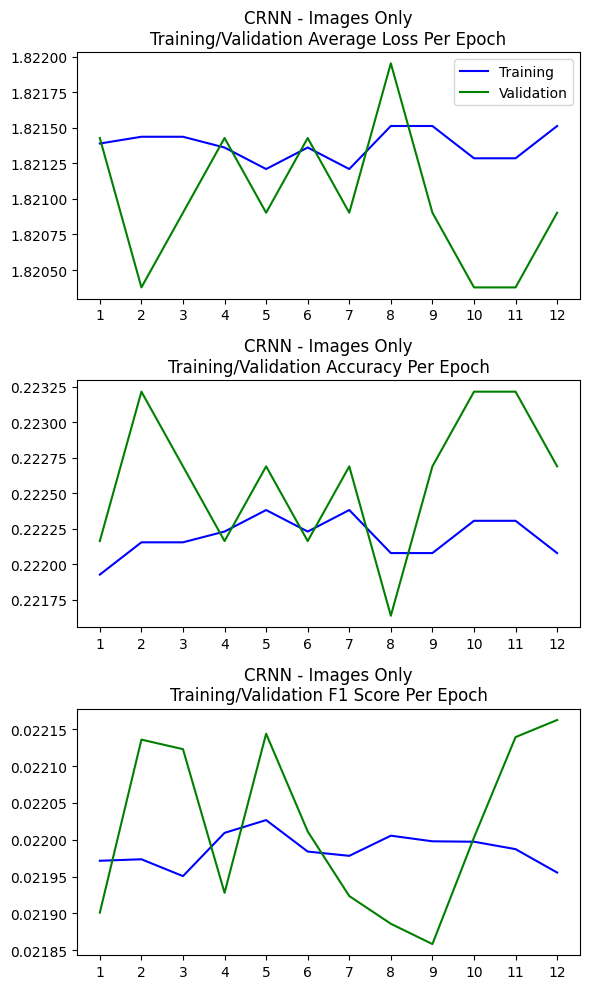

In [46]:
plot_train_metrics('CRNN - Images Only', num_epoch, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch)

In [98]:
# Set Parameters for CRNN Model
input_size = 256  
hidden_size = 128
num_layers = 2
num_classes = len(label_names)

# Create CRNN model instance
model = CRNN(input_size, hidden_size, num_layers, num_classes).to(device)
#CRNN Model Eval
model.load_state_dict(torch.load('CRNN_Model.pth'))
model.eval()

CRNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rnn): LSTM(256, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [99]:
#Eval Trained Model
test_dataloader = test_dataloader
include_non_image_data = False

truths, predictions = model_eval(model, test_dataloader, include_non_image_data)

100%|██████████| 146/146 [00:50<00:00,  2.91it/s]


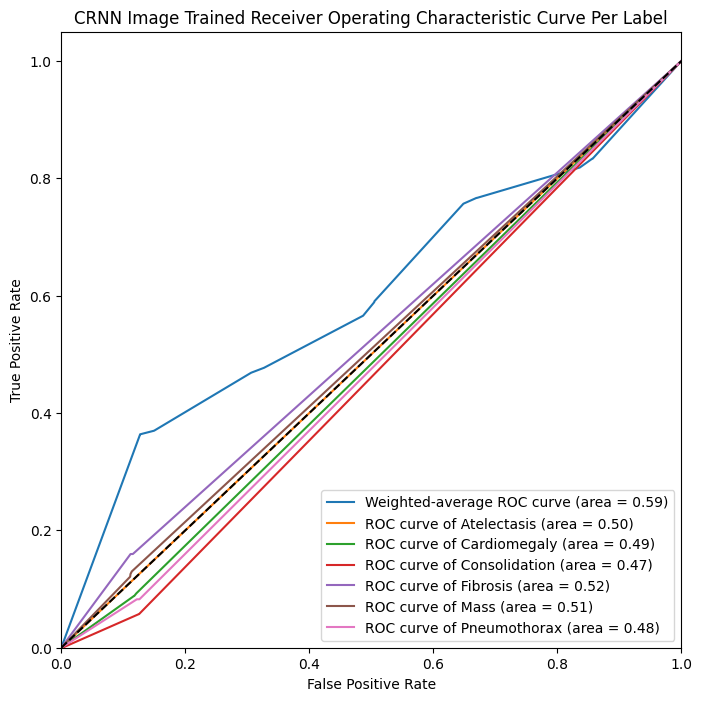

In [100]:
title = 'CRNN Image Trained Receiver Operating Characteristic Curve Per Label'
multilabel_ROC_plot(truths, predictions, title, label_names)

In [101]:
truths, predictions = predictions_w_thresholds(truths, predictions,0.5)

print(classification_report(truths, predictions,target_names=label_names, zero_division = 0))

               precision    recall  f1-score   support

  Atelectasis       0.36      1.00      0.53       850
 Cardiomegaly       0.00      0.00      0.00       227
Consolidation       0.00      0.00      0.00       245
     Fibrosis       0.00      0.00      0.00       144
         Mass       0.00      0.00      0.00       446
 Pneumothorax       0.00      0.00      0.00       424

    micro avg       0.36      0.36      0.36      2336
    macro avg       0.06      0.17      0.09      2336
 weighted avg       0.13      0.36      0.19      2336
  samples avg       0.36      0.36      0.36      2336



## CRNN with non-visual data

In [109]:
class CRNN_w_NVdata(nn.Module):
    def __init__(self, input_size_img, input_size_nv, hidden_size, num_layers, num_classes):
        super(CRNN_w_NVdata, self).__init__()
        
        # Convolutional layers for image data
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Recurrent layers for non-visual data
        self.rnn = nn.LSTM(input_size_nv, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * (input_size_img[1] // 4) * (input_size_img[2] // 4) + hidden_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, img, nv_data):
        # Convolutional layers for image data
        img = torch.relu(self.conv1(img))
        img = self.pool(img)
        img = torch.relu(self.conv2(img))
        img = self.pool(img)
        
        # Flatten image data
        img = img.view(img.size(0), -1)
        
        # Recurrent layers for non-visual data
        nv_data, _ = self.rnn(nv_data)

        # Concatenate image and non-visual data
        combined_data = torch.cat((img, nv_data), dim=1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(combined_data))
        x = self.fc2(x)
        x = F.softmax(x, dim = 1)
        return x

In [110]:
# Set Parameters for CRNN Model with Image and Non-Visual Data
input_size_img = (1, 1024, 1024) 
input_size_nv = 3  # Number of non-visual features
hidden_size = 128
num_layers = 2
num_classes = len(label_names)

# Create CRNN model instance
model = CRNN_w_NVdata(input_size_img, input_size_nv, hidden_size, num_layers, num_classes).to(device)

In [45]:
# Set Parameters for Training CRNN Model with Image and Non-Visual Data
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

num_epoch = 12
threshold = 0.5
include_non_image_data = True
model_file = 'CRNN_Image_w_NV_Model.pth'

# Train CRNN model
model, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch = train_model(
    model,
    train_dataloader,
    validation_dataloader,
    optimizer,
    loss_fn,
    num_epoch,
    threshold,
    include_non_image_data,
    model_file)

************************************Epoch: 1************************************
Training Phase:


100%|██████████| 826/826 [14:13<00:00,  1.03s/it]


Train set:
	 Average Accuracy For Epoch: 0.15594733656174334 
	 Average Cross Entropy Loss for Epoch: 1.887716643746771
	 Average F1 for Epoch: 0.016206501903732004
Validation Phase:


100%|██████████| 119/119 [01:21<00:00,  1.46it/s]


Validation set: 
	 Average Accuracy: 0.15546218487394958 
	 Average Cross Entropy Loss: 1.8881297902900631
	 Average F1 for Epoch: 0.016181883204543626 
Time elapse: 00:15:35
************************************Epoch: 2************************************
Training Phase:


100%|██████████| 826/826 [12:10<00:00,  1.13it/s]


Train set:
	 Average Accuracy For Epoch: 0.15556900726392253 
	 Average Cross Entropy Loss for Epoch: 1.8880229681802432
	 Average F1 for Epoch: 0.016180760447999785
Validation Phase:


100%|██████████| 119/119 [01:23<00:00,  1.42it/s]


Validation set: 
	 Average Accuracy: 0.15546218487394958 
	 Average Cross Entropy Loss: 1.8881297902900631
	 Average F1 for Epoch: 0.016089086915374057 
Time elapse: 00:29:09
************************************Epoch: 3************************************
Training Phase:


100%|██████████| 826/826 [12:06<00:00,  1.14it/s]


Train set:
	 Average Accuracy For Epoch: 0.15556900726392253 
	 Average Cross Entropy Loss for Epoch: 1.8880229677472795
	 Average F1 for Epoch: 0.01615397279276452
Validation Phase:


100%|██████████| 119/119 [01:18<00:00,  1.52it/s]


Validation set: 
	 Average Accuracy: 0.15546218487394958 
	 Average Cross Entropy Loss: 1.888129791291822
	 Average F1 for Epoch: 0.016101549101144114 
Time elapse: 00:42:34
************************************Epoch: 4************************************
Training Phase:


100%|██████████| 826/826 [12:46<00:00,  1.08it/s]


Train set:
	 Average Accuracy For Epoch: 0.15564467312348668 
	 Average Cross Entropy Loss for Epoch: 1.8879473024650002
	 Average F1 for Epoch: 0.016218704246562684
Validation Phase:


100%|██████████| 119/119 [01:22<00:00,  1.45it/s]


Validation set: 
	 Average Accuracy: 0.1559873949579832 
	 Average Cross Entropy Loss: 1.8876045792042708
	 Average F1 for Epoch: 0.016176617940543293 
Time elapse: 00:56:43
************************************Epoch: 5************************************
Training Phase:


100%|██████████| 826/826 [12:10<00:00,  1.13it/s]


Train set:
	 Average Accuracy For Epoch: 0.15556900726392253 
	 Average Cross Entropy Loss for Epoch: 1.8880229677472795
	 Average F1 for Epoch: 0.01612890611612836
Validation Phase:


100%|██████████| 119/119 [01:31<00:00,  1.29it/s]


Validation set: 
	 Average Accuracy: 0.15546218487394958 
	 Average Cross Entropy Loss: 1.8881297902900631
	 Average F1 for Epoch: 0.016267008726748005 
Time elapse: 01:10:25
************************************Epoch: 6************************************
Training Phase:


100%|██████████| 826/826 [12:17<00:00,  1.12it/s]


Train set:
	 Average Accuracy For Epoch: 0.15556900726392253 
	 Average Cross Entropy Loss for Epoch: 1.8880229677472795
	 Average F1 for Epoch: 0.016206306849081243
Validation Phase:


100%|██████████| 119/119 [01:25<00:00,  1.39it/s]


Validation set: 
	 Average Accuracy: 0.1559873949579832 
	 Average Cross Entropy Loss: 1.8876045812077884
	 Average F1 for Epoch: 0.016215018890565855 
Time elapse: 01:24:08
************************************Epoch: 7************************************
Training Phase:


100%|██████████| 826/826 [12:16<00:00,  1.12it/s]


Train set:
	 Average Accuracy For Epoch: 0.15549334140435836 
	 Average Cross Entropy Loss for Epoch: 1.8880986340398072
	 Average F1 for Epoch: 0.016136738950298303
Validation Phase:


100%|██████████| 119/119 [01:19<00:00,  1.50it/s]


Validation set: 
	 Average Accuracy: 0.1559873949579832 
	 Average Cross Entropy Loss: 1.8876045802060295
	 Average F1 for Epoch: 0.016403110639133186 
Time elapse: 01:37:44
************************************Epoch: 8************************************
Training Phase:


100%|██████████| 826/826 [12:10<00:00,  1.13it/s]


Train set:
	 Average Accuracy For Epoch: 0.15549334140435836 
	 Average Cross Entropy Loss for Epoch: 1.8880986336068437
	 Average F1 for Epoch: 0.016176769853843604
Validation Phase:


100%|██████████| 119/119 [01:27<00:00,  1.37it/s]


Validation set: 
	 Average Accuracy: 0.15546218487394958 
	 Average Cross Entropy Loss: 1.888129791291822
	 Average F1 for Epoch: 0.016315982251799272 
Time elapse: 01:51:22
************************************Epoch: 9************************************
Training Phase:


100%|██████████| 826/826 [12:20<00:00,  1.12it/s]


Train set:
	 Average Accuracy For Epoch: 0.15549334140435836 
	 Average Cross Entropy Loss for Epoch: 1.8880986331738803
	 Average F1 for Epoch: 0.01618343689899883
Validation Phase:


100%|██████████| 119/119 [01:20<00:00,  1.48it/s]


Validation set: 
	 Average Accuracy: 0.15546218487394958 
	 Average Cross Entropy Loss: 1.888129791291822
	 Average F1 for Epoch: 0.016269179184214593 
Time elapse: 02:05:03
***********************************Epoch: 10************************************
Training Phase:


100%|██████████| 826/826 [12:00<00:00,  1.15it/s]


Train set:
	 Average Accuracy For Epoch: 0.15564467312348668 
	 Average Cross Entropy Loss for Epoch: 1.8879473017433943
	 Average F1 for Epoch: 0.016126165676786635
Validation Phase:


100%|██████████| 119/119 [01:23<00:00,  1.43it/s]


Validation set: 
	 Average Accuracy: 0.15546218487394958 
	 Average Cross Entropy Loss: 1.8881297882865458
	 Average F1 for Epoch: 0.016296312126501754 
Time elapse: 02:18:27
***********************************Epoch: 11************************************
Training Phase:


100%|██████████| 826/826 [13:09<00:00,  1.05it/s]


Train set:
	 Average Accuracy For Epoch: 0.15556900726392253 
	 Average Cross Entropy Loss for Epoch: 1.8880229678916007
	 Average F1 for Epoch: 0.01611020561645007
Validation Phase:


100%|██████████| 119/119 [01:31<00:00,  1.30it/s]


Validation set: 
	 Average Accuracy: 0.15493697478991597 
	 Average Cross Entropy Loss: 1.8886550013758556
	 Average F1 for Epoch: 0.016051609277933296 
Time elapse: 02:33:07
***********************************Epoch: 12************************************
Training Phase:


100%|██████████| 826/826 [12:37<00:00,  1.09it/s]


Train set:
	 Average Accuracy For Epoch: 0.15549334140435836 
	 Average Cross Entropy Loss for Epoch: 1.8880986338954862
	 Average F1 for Epoch: 0.016206021681084936
Validation Phase:


100%|██████████| 119/119 [01:22<00:00,  1.44it/s]


Validation set: 
	 Average Accuracy: 0.15546218487394958 
	 Average Cross Entropy Loss: 1.888129791291822
	 Average F1 for Epoch: 0.016199189123064527 
Time elapse: 02:47:08


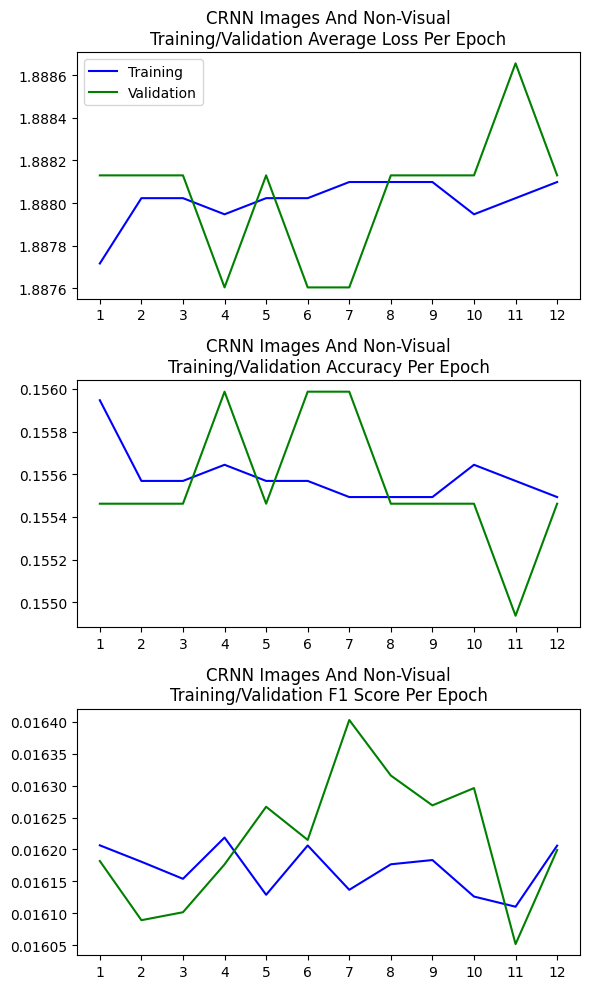

In [46]:
plot_train_metrics('CRNN Images And Non-Visual', num_epoch, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch)

In [111]:
#Load Trained Model
model.load_state_dict(torch.load('CRNN_Image_w_NV_Model.pth'))
model.eval()

CRNN_w_NVdata(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (rnn): LSTM(3, 128, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=2097280, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)

In [112]:
#Eval Trained Model
model = model
test_dataloader = test_dataloader
include_non_image_data = True

truths, predictions = model_eval(model, test_dataloader, include_non_image_data)

100%|██████████| 146/146 [01:34<00:00,  1.54it/s]


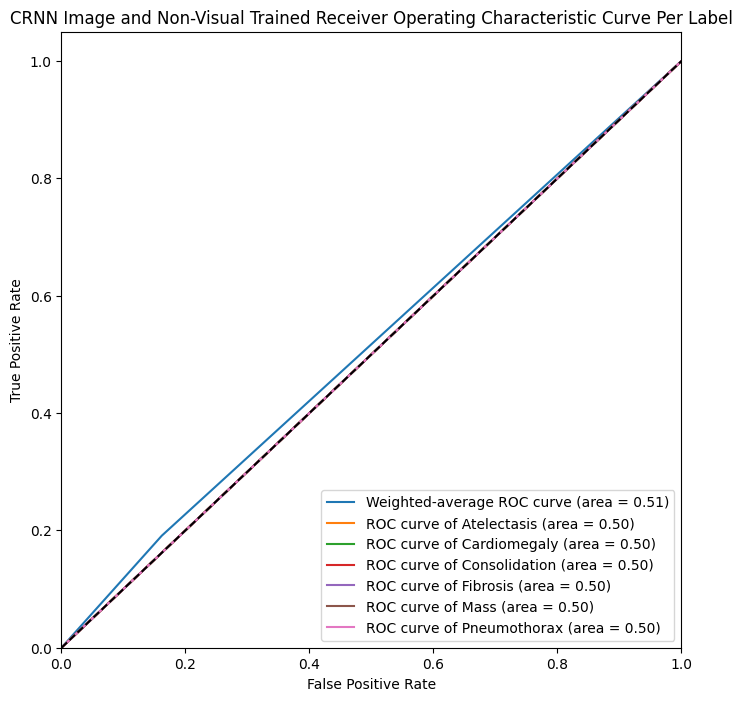

In [113]:
title = 'CRNN Image and Non-Visual Trained Receiver Operating Characteristic Curve Per Label'
multilabel_ROC_plot(truths, predictions, title, label_names)

In [114]:
truths, predictions = predictions_w_thresholds(truths, predictions,0.5)

print(classification_report(truths, predictions,target_names=label_names, zero_division = 0))

               precision    recall  f1-score   support

  Atelectasis       0.00      0.00      0.00       850
 Cardiomegaly       0.00      0.00      0.00       227
Consolidation       0.00      0.00      0.00       245
     Fibrosis       0.00      0.00      0.00       144
         Mass       0.19      1.00      0.32       446
 Pneumothorax       0.00      0.00      0.00       424

    micro avg       0.19      0.19      0.19      2336
    macro avg       0.03      0.17      0.05      2336
 weighted avg       0.04      0.19      0.06      2336
  samples avg       0.19      0.19      0.19      2336



## Dynamic Affine Map Transform (DAFT) CNN - Images Only

In [115]:
class DAFT(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(DAFT, self).__init__()
        
        # Define DAFT layers
        self.daft1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.daft2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Define fully connected layers
        self.fc1 = nn.Linear(32 * (input_shape[1] // 4) * (input_shape[2] // 4), 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Apply DAFT layers
        x = self.daft1(x)
        x = self.daft2(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim = 1)

        return x

In [116]:
# Set Parameters for DAFT Model
input_shape = (1, 1024, 1024)  
num_classes = len(label_names)

# Create DAFT model instance
model = DAFT(input_shape, num_classes).to(device)

# Print model summary
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1       [-1, 16, 1024, 1024]             160
              ReLU-2       [-1, 16, 1024, 1024]               0
         MaxPool2d-3         [-1, 16, 512, 512]               0
            Conv2d-4         [-1, 32, 512, 512]           4,640
              ReLU-5         [-1, 32, 512, 512]               0
         MaxPool2d-6         [-1, 32, 256, 256]               0
            Linear-7                  [-1, 256]     536,871,168
            Linear-8                    [-1, 6]           1,542
Total params: 536,877,510
Trainable params: 536,877,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 4.00
Forward/backward pass size (MB): 432.00
Params size (MB): 2048.03
Estimated Total Size (MB): 2484.03
----------------------------------------------------------------


In [44]:
# Set Parameters for Training DAFT Model
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
num_epoch = 12
threshold = 0.5
include_non_image_data = False
model_file = 'DAFT_Model.pth'

# Train DAFT model
model, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch = train_model(
    model,
    train_dataloader,
    validation_dataloader,
    optimizer,
    loss_fn,
    num_epoch,
    threshold,
    include_non_image_data,
    model_file
)

************************************Epoch: 1************************************
Training Phase:


100%|██████████| 826/826 [08:58<00:00,  1.53it/s]


Train set:
	 Average Accuracy For Epoch: 0.2217766343825666 
	 Average Cross Entropy Loss for Epoch: 1.821663203164394
	 Average F1 for Epoch: 0.02195815023081198
Validation Phase:


100%|██████████| 119/119 [01:24<00:00,  1.41it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.8209028995337606
	 Average F1 for Epoch: 0.02208630845505299 
Time elapse: 00:10:22
************************************Epoch: 2************************************
Training Phase:


100%|██████████| 826/826 [12:02<00:00,  1.14it/s]


Train set:
	 Average Accuracy For Epoch: 0.22230629539951574 
	 Average Cross Entropy Loss for Epoch: 1.8212856796116863
	 Average F1 for Epoch: 0.021987262068415468
Validation Phase:


100%|██████████| 119/119 [01:29<00:00,  1.33it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.8209028995337606
	 Average F1 for Epoch: 0.02197224575248012 
Time elapse: 00:23:54
************************************Epoch: 3************************************
Training Phase:


100%|██████████| 826/826 [12:35<00:00,  1.09it/s]


Train set:
	 Average Accuracy For Epoch: 0.22230629539951574 
	 Average Cross Entropy Loss for Epoch: 1.8212856804776134
	 Average F1 for Epoch: 0.02195322824840712
Validation Phase:


100%|██████████| 119/119 [01:27<00:00,  1.35it/s]


Validation set: 
	 Average Accuracy: 0.22321428571428573 
	 Average Cross Entropy Loss: 1.8203776904514857
	 Average F1 for Epoch: 0.021961029224354504 
Time elapse: 00:37:57
************************************Epoch: 4************************************
Training Phase:


100%|██████████| 826/826 [12:48<00:00,  1.07it/s]


Train set:
	 Average Accuracy For Epoch: 0.2221549636803874 
	 Average Cross Entropy Loss for Epoch: 1.8214370119080994
	 Average F1 for Epoch: 0.021945198580843463
Validation Phase:


100%|██████████| 119/119 [01:29<00:00,  1.34it/s]


Validation set: 
	 Average Accuracy: 0.22216386554621848 
	 Average Cross Entropy Loss: 1.8214281096177942
	 Average F1 for Epoch: 0.021910476073018704 
Time elapse: 00:52:15
************************************Epoch: 5************************************
Training Phase:


100%|██████████| 826/826 [12:01<00:00,  1.15it/s]


Train set:
	 Average Accuracy For Epoch: 0.22223062953995157 
	 Average Cross Entropy Loss for Epoch: 1.821361345904214
	 Average F1 for Epoch: 0.022038191716883003
Validation Phase:


100%|██████████| 119/119 [01:34<00:00,  1.26it/s]


Validation set: 
	 Average Accuracy: 0.22216386554621848 
	 Average Cross Entropy Loss: 1.8214281086160355
	 Average F1 for Epoch: 0.02188404030995689 
Time elapse: 01:05:50
************************************Epoch: 6************************************
Training Phase:


100%|██████████| 826/826 [13:39<00:00,  1.01it/s]


Train set:
	 Average Accuracy For Epoch: 0.22200363196125908 
	 Average Cross Entropy Loss for Epoch: 1.8215883434829065
	 Average F1 for Epoch: 0.022055931254440844
Validation Phase:


100%|██████████| 119/119 [01:29<00:00,  1.33it/s]


Validation set: 
	 Average Accuracy: 0.22321428571428573 
	 Average Cross Entropy Loss: 1.8203776904514857
	 Average F1 for Epoch: 0.021930038387516494 
Time elapse: 01:20:59
************************************Epoch: 7************************************
Training Phase:


100%|██████████| 826/826 [11:13<00:00,  1.23it/s]


Train set:
	 Average Accuracy For Epoch: 0.22207929782082325 
	 Average Cross Entropy Loss for Epoch: 1.8215126776233423
	 Average F1 for Epoch: 0.021956001472587545
Validation Phase:


100%|██████████| 119/119 [01:16<00:00,  1.55it/s]


Validation set: 
	 Average Accuracy: 0.22268907563025211 
	 Average Cross Entropy Loss: 1.8209029005355193
	 Average F1 for Epoch: 0.022085776923054377 
Time elapse: 01:33:30
************************************Epoch: 8************************************
Training Phase:


100%|██████████| 826/826 [08:38<00:00,  1.59it/s]


Train set:
	 Average Accuracy For Epoch: 0.22223062953995157 
	 Average Cross Entropy Loss for Epoch: 1.821361345904214
	 Average F1 for Epoch: 0.02198322217964923
Validation Phase:


100%|██████████| 119/119 [01:07<00:00,  1.75it/s]


Validation set: 
	 Average Accuracy: 0.22216386554621848 
	 Average Cross Entropy Loss: 1.821428110619553
	 Average F1 for Epoch: 0.02215040880378058 
Time elapse: 01:43:16
************************************Epoch: 9************************************
Training Phase:


100%|██████████| 826/826 [09:02<00:00,  1.52it/s]


Train set:
	 Average Accuracy For Epoch: 0.22230629539951574 
	 Average Cross Entropy Loss for Epoch: 1.8212856799003287
	 Average F1 for Epoch: 0.021959204615771687
Validation Phase:


100%|██████████| 119/119 [01:08<00:00,  1.75it/s]


Validation set: 
	 Average Accuracy: 0.22216386554621848 
	 Average Cross Entropy Loss: 1.8214281086160355
	 Average F1 for Epoch: 0.02198516839074905 
Time elapse: 01:53:26
***********************************Epoch: 10************************************
Training Phase:


100%|██████████| 826/826 [08:47<00:00,  1.57it/s]


Train set:
	 Average Accuracy For Epoch: 0.2221549636803874 
	 Average Cross Entropy Loss for Epoch: 1.821437011475136
	 Average F1 for Epoch: 0.02193932142875701
Validation Phase:


100%|██████████| 119/119 [01:01<00:00,  1.92it/s]


Validation set: 
	 Average Accuracy: 0.22216386554621848 
	 Average Cross Entropy Loss: 1.821428110619553
	 Average F1 for Epoch: 0.02188228081485368 
Time elapse: 02:03:16
***********************************Epoch: 11************************************
Training Phase:


100%|██████████| 826/826 [10:00<00:00,  1.38it/s]


Train set:
	 Average Accuracy For Epoch: 0.2221549636803874 
	 Average Cross Entropy Loss for Epoch: 1.821437011619457
	 Average F1 for Epoch: 0.021937046170627878
Validation Phase:


100%|██████████| 119/119 [01:17<00:00,  1.53it/s]


Validation set: 
	 Average Accuracy: 0.22216386554621848 
	 Average Cross Entropy Loss: 1.821428110619553
	 Average F1 for Epoch: 0.02201959790430362 
Time elapse: 02:14:34
***********************************Epoch: 12************************************
Training Phase:


100%|██████████| 826/826 [08:54<00:00,  1.54it/s]


Train set:
	 Average Accuracy For Epoch: 0.22223062953995157 
	 Average Cross Entropy Loss for Epoch: 1.8213613463371776
	 Average F1 for Epoch: 0.021923877771980915
Validation Phase:


100%|██████████| 119/119 [01:11<00:00,  1.67it/s]


Validation set: 
	 Average Accuracy: 0.22321428571428573 
	 Average Cross Entropy Loss: 1.820377689449727
	 Average F1 for Epoch: 0.02212481185934072 
Time elapse: 02:24:40


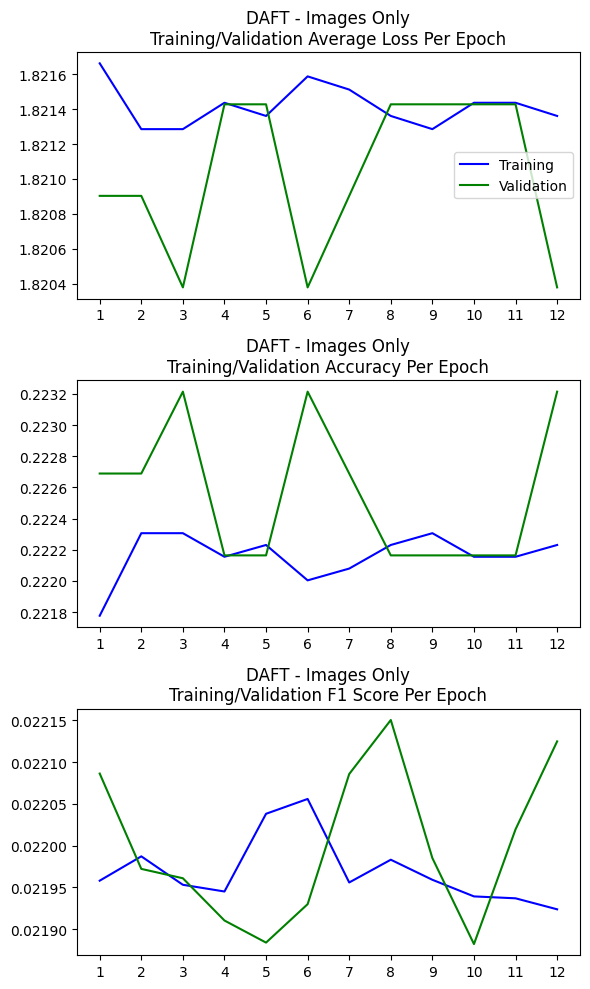

In [45]:
plot_train_metrics('DAFT - Images Only', num_epoch, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch)

In [117]:
#Load Trained Model
model.load_state_dict(torch.load('DAFT_Model.pth'))
model.eval()

DAFT(
  (daft1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (daft2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2097152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)

In [120]:
#Eval Trained Model
test_dataloader = test_dataloader
include_non_image_data = False

truths, predictions = model_eval(model, test_dataloader, include_non_image_data)

100%|██████████| 146/146 [00:38<00:00,  3.82it/s]


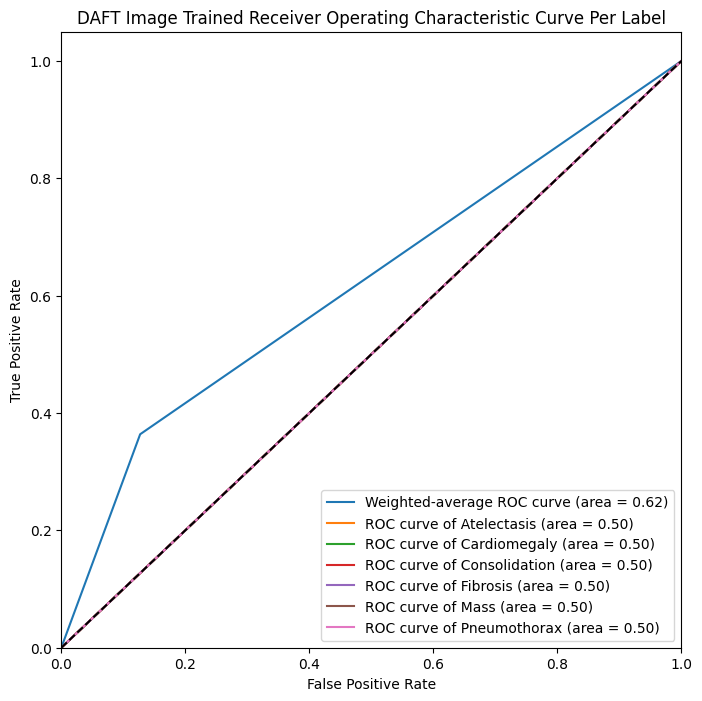

In [121]:
title = 'DAFT Image Trained Receiver Operating Characteristic Curve Per Label'
multilabel_ROC_plot(truths, predictions, title, label_names)

In [122]:
truths, predictions = predictions_w_thresholds(truths, predictions,0.5)

print(classification_report(truths, predictions,target_names=label_names, zero_division = 0))

               precision    recall  f1-score   support

  Atelectasis       0.36      1.00      0.53       850
 Cardiomegaly       0.00      0.00      0.00       227
Consolidation       0.00      0.00      0.00       245
     Fibrosis       0.00      0.00      0.00       144
         Mass       0.00      0.00      0.00       446
 Pneumothorax       0.00      0.00      0.00       424

    micro avg       0.36      0.36      0.36      2336
    macro avg       0.06      0.17      0.09      2336
 weighted avg       0.13      0.36      0.19      2336
  samples avg       0.36      0.36      0.36      2336



## DAFT for images and non-visual data

In [123]:
class DAFT_w_NVdata(nn.Module):
    def __init__(self, input_shape_img, input_size_nv, num_classes):
        super(DAFT_w_NVdata, self).__init__()
        
        # Define DAFT layers for image data
        self.daft1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.daft2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Define fully connected layers for non-visual data
        self.fc_nv = nn.Linear(input_size_nv, 32)
        
        # Define fully connected layers for combined data
        self.fc1 = nn.Linear(32 * (input_shape_img[1] // 4) * (input_shape_img[2] // 4) + 32, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, img, nv_data):
        # Apply DAFT layers to image data
        img = self.daft1(img)
        img = self.daft2(img)
        
        # Flatten image data
        img = img.view(img.size(0), -1)
        
        # Fully connected layer for non-visual data
        nv_data = torch.relu(self.fc_nv(nv_data))
        
        # Concatenate image and non-visual data
        combined_data = torch.cat((img, nv_data), dim=1)
        
        # Fully connected layers for combined data
        x = torch.relu(self.fc1(combined_data))
        x = self.fc2(x)
        x = F.softmax(x, dim = 1)
        return x

In [124]:
# Set Parameters for DAFT Model with Image and Non-Visual Data
input_shape_img = (1, 1024, 1024)  
input_size_nv = 3  # Number of non-visual features
num_classes = len(label_names)

# Create DAFT model instance
model = DAFT_w_NVdata(input_shape_img, input_size_nv, num_classes).to(device)

In [39]:
# Set Parameters for Training DAFT Model with Image and Non-Visual Data
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
num_epoch = 12
threshold = 0.5
include_non_image_data = True
model_file = 'DAFT_Image_w_NV_Model.pth'

# Train DAFT model
model, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch = train_model(
    model,
    train_dataloader,
    validation_dataloader,
    optimizer,
    loss_fn,
    num_epoch,
    threshold,
    include_non_image_data,
    model_file
)

************************************Epoch: 1************************************
Training Phase:


100%|██████████| 826/826 [12:16<00:00,  1.12it/s]


Train set:
	 Average Accuracy For Epoch: 0.15549334140435836 
	 Average Cross Entropy Loss for Epoch: 1.88794490485734
	 Average F1 for Epoch: 0.01614487517418404
Validation Phase:


100%|██████████| 119/119 [01:18<00:00,  1.52it/s]


Validation set: 
	 Average Accuracy: 0.1559873949579832 
	 Average Cross Entropy Loss: 1.8876045792042708
	 Average F1 for Epoch: 0.016150069714739593 
Time elapse: 00:13:34
************************************Epoch: 2************************************
Training Phase:


100%|██████████| 826/826 [08:54<00:00,  1.54it/s]


Train set:
	 Average Accuracy For Epoch: 0.15556900726392253 
	 Average Cross Entropy Loss for Epoch: 1.8880229674586373
	 Average F1 for Epoch: 0.01616982692112993
Validation Phase:


100%|██████████| 119/119 [01:15<00:00,  1.57it/s]


Validation set: 
	 Average Accuracy: 0.15493697478991597 
	 Average Cross Entropy Loss: 1.8886550003740967
	 Average F1 for Epoch: 0.016133459669635718 
Time elapse: 00:23:45
************************************Epoch: 3************************************
Training Phase:


100%|██████████| 826/826 [08:32<00:00,  1.61it/s]


Train set:
	 Average Accuracy For Epoch: 0.15556900726392253 
	 Average Cross Entropy Loss for Epoch: 1.8880229674586373
	 Average F1 for Epoch: 0.016244047984186542
Validation Phase:


100%|██████████| 119/119 [01:20<00:00,  1.48it/s]


Validation set: 
	 Average Accuracy: 0.1559873949579832 
	 Average Cross Entropy Loss: 1.8876045792042708
	 Average F1 for Epoch: 0.01634156524041267 
Time elapse: 00:33:37
************************************Epoch: 4************************************
Training Phase:


100%|██████████| 826/826 [10:55<00:00,  1.26it/s]


Train set:
	 Average Accuracy For Epoch: 0.15549334140435836 
	 Average Cross Entropy Loss for Epoch: 1.8880986338954862
	 Average F1 for Epoch: 0.01611638166965258
Validation Phase:


100%|██████████| 119/119 [01:06<00:00,  1.80it/s]


Validation set: 
	 Average Accuracy: 0.1559873949579832 
	 Average Cross Entropy Loss: 1.8876045812077884
	 Average F1 for Epoch: 0.016271728285288556 
Time elapse: 00:45:38
************************************Epoch: 5************************************
Training Phase:


100%|██████████| 826/826 [10:26<00:00,  1.32it/s]


Train set:
	 Average Accuracy For Epoch: 0.15534200968523001 
	 Average Cross Entropy Loss for Epoch: 1.8882499648930084
	 Average F1 for Epoch: 0.016140596390806245
Validation Phase:


100%|██████████| 119/119 [01:28<00:00,  1.35it/s]


Validation set: 
	 Average Accuracy: 0.15546218487394958 
	 Average Cross Entropy Loss: 1.8881297902900631
	 Average F1 for Epoch: 0.016270866166149325 
Time elapse: 00:57:33
************************************Epoch: 6************************************
Training Phase:


100%|██████████| 826/826 [11:11<00:00,  1.23it/s]


Train set:
	 Average Accuracy For Epoch: 0.15564467312348668 
	 Average Cross Entropy Loss for Epoch: 1.887947301599073
	 Average F1 for Epoch: 0.01615030234608346
Validation Phase:


100%|██████████| 119/119 [01:28<00:00,  1.35it/s]


Validation set: 
	 Average Accuracy: 0.15546218487394958 
	 Average Cross Entropy Loss: 1.8881297902900631
	 Average F1 for Epoch: 0.016281476470877274 
Time elapse: 01:10:13
************************************Epoch: 7************************************
Training Phase:


100%|██████████| 826/826 [09:42<00:00,  1.42it/s]


Train set:
	 Average Accuracy For Epoch: 0.15556900726392253 
	 Average Cross Entropy Loss for Epoch: 1.8880229677472795
	 Average F1 for Epoch: 0.016215942296311233
Validation Phase:


100%|██████████| 119/119 [01:03<00:00,  1.87it/s]


Validation set: 
	 Average Accuracy: 0.15546218487394958 
	 Average Cross Entropy Loss: 1.8881297892883044
	 Average F1 for Epoch: 0.01634784226102484 
Time elapse: 01:20:59
************************************Epoch: 8************************************
Training Phase:


100%|██████████| 826/826 [07:55<00:00,  1.74it/s]


Train set:
	 Average Accuracy For Epoch: 0.15556900726392253 
	 Average Cross Entropy Loss for Epoch: 1.8880229676029585
	 Average F1 for Epoch: 0.01620072524125668
Validation Phase:


100%|██████████| 119/119 [00:43<00:00,  2.71it/s]


Validation set: 
	 Average Accuracy: 0.15493697478991597 
	 Average Cross Entropy Loss: 1.8886550013758556
	 Average F1 for Epoch: 0.01611189755049665 
Time elapse: 01:29:39
************************************Epoch: 9************************************
Training Phase:


100%|██████████| 826/826 [11:29<00:00,  1.20it/s]


Train set:
	 Average Accuracy For Epoch: 0.1554176755447942 
	 Average Cross Entropy Loss for Epoch: 1.8881742997550504
	 Average F1 for Epoch: 0.016198529582311928
Validation Phase:


100%|██████████| 119/119 [01:24<00:00,  1.41it/s]


Validation set: 
	 Average Accuracy: 0.1559873949579832 
	 Average Cross Entropy Loss: 1.8876045812077884
	 Average F1 for Epoch: 0.016254518098840397 
Time elapse: 01:42:33
***********************************Epoch: 10************************************
Training Phase:


100%|██████████| 826/826 [08:21<00:00,  1.65it/s]


Train set:
	 Average Accuracy For Epoch: 0.15564467312348668 
	 Average Cross Entropy Loss for Epoch: 1.8879473005888248
	 Average F1 for Epoch: 0.01616141140526894
Validation Phase:


100%|██████████| 119/119 [00:32<00:00,  3.65it/s]


Validation set: 
	 Average Accuracy: 0.15493697478991597 
	 Average Cross Entropy Loss: 1.888654999372338
	 Average F1 for Epoch: 0.016117860034528832 
Time elapse: 01:51:27
***********************************Epoch: 11************************************
Training Phase:


100%|██████████| 826/826 [05:47<00:00,  2.38it/s]


Train set:
	 Average Accuracy For Epoch: 0.15556900726392253 
	 Average Cross Entropy Loss for Epoch: 1.8880229677472795
	 Average F1 for Epoch: 0.016174372599050222
Validation Phase:


100%|██████████| 119/119 [00:32<00:00,  3.66it/s]


Validation set: 
	 Average Accuracy: 0.1559873949579832 
	 Average Cross Entropy Loss: 1.8876045802060295
	 Average F1 for Epoch: 0.01627047760656 
Time elapse: 01:57:47
***********************************Epoch: 12************************************
Training Phase:


100%|██████████| 826/826 [08:46<00:00,  1.57it/s]


Train set:
	 Average Accuracy For Epoch: 0.15549334140435836 
	 Average Cross Entropy Loss for Epoch: 1.8880986327409166
	 Average F1 for Epoch: 0.016203249930700506
Validation Phase:


100%|██████████| 119/119 [01:20<00:00,  1.47it/s]


Validation set: 
	 Average Accuracy: 0.15546218487394958 
	 Average Cross Entropy Loss: 1.8881297892883044
	 Average F1 for Epoch: 0.016045921446198097 
Time elapse: 02:07:54


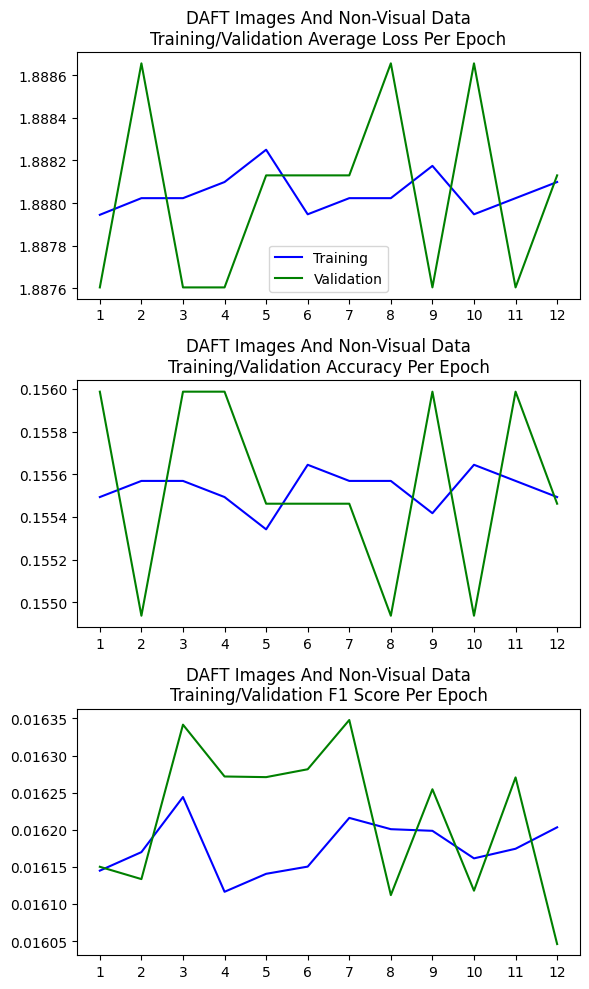

In [40]:
plot_train_metrics('DAFT Images And Non-Visual Data', num_epoch, t_acc_per_epoch, t_loss_per_epoch, t_f1_per_epoch, v_acc_per_epoch, v_loss_per_epoch, v_f1_per_epoch)

In [125]:
#Load Trained Model
model.load_state_dict(torch.load('DAFT_Image_w_NV_Model.pth'))
model.eval()

DAFT_w_NVdata(
  (daft1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (daft2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_nv): Linear(in_features=3, out_features=32, bias=True)
  (fc1): Linear(in_features=2097184, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)

In [127]:
#Eval Trained Model
test_dataloader = test_dataloader
include_non_image_data = True

truths, predictions = model_eval(model, test_dataloader, include_non_image_data)

100%|██████████| 146/146 [00:59<00:00,  2.46it/s]


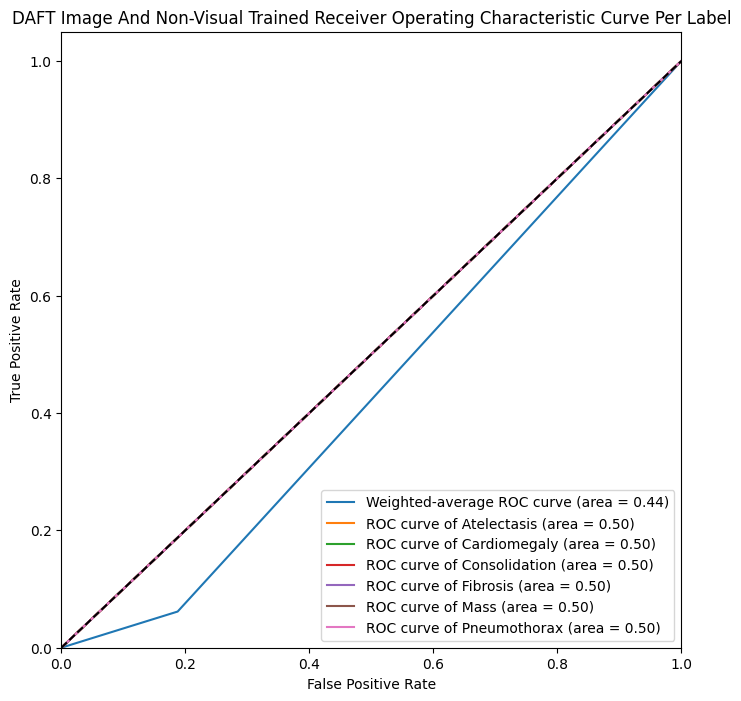

In [128]:
title = 'DAFT Image And Non-Visual Trained Receiver Operating Characteristic Curve Per Label'
multilabel_ROC_plot(truths, predictions, title, label_names)

In [129]:
truths, predictions = predictions_w_thresholds(truths, predictions,0.5)

print(classification_report(truths, predictions,target_names=label_names, zero_division = 0))

               precision    recall  f1-score   support

  Atelectasis       0.00      0.00      0.00       850
 Cardiomegaly       0.00      0.00      0.00       227
Consolidation       0.00      0.00      0.00       245
     Fibrosis       0.06      1.00      0.12       144
         Mass       0.00      0.00      0.00       446
 Pneumothorax       0.00      0.00      0.00       424

    micro avg       0.06      0.06      0.06      2336
    macro avg       0.01      0.17      0.02      2336
 weighted avg       0.00      0.06      0.01      2336
  samples avg       0.06      0.06      0.06      2336

